In [1]:
!python --version


Python 3.11.11


In [2]:
# We are using PyTorch Geometric as it’s widely used for GNNs and integrates well with PyTorch.
# We also install NetworkX for handling graph structures and pandas for data manipulation.

!pip uninstall -y torch torchvision torchaudio torch-geometric
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu118
!pip install torch-geometric
!pip install pandas matplotlib networkx



Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in links: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 

In [3]:
# Standard libraries
import os
import sys
import json
import random
import pickle
import platform
import subprocess
import zipfile

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pkg_resources

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Network analysis
import networkx as nx

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, TransformerConv

# Google Colab specific
from google.colab import files

<ipython-input-3-9094256379c7>:16: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [5]:
# upload data
# the data I'm using is coming from here on kaggle: https://www.kaggle.com/datasets/azminetoushikwasi/supplygraph-supply-chain-planning-using-gnns?resource=download
# I just downloaded the data as a .zip and then uploaded it here
uploaded = files.upload()


Saving supplygraph.zip to supplygraph.zip


In [6]:
# unzip
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall("data")


# Overview of Dataset
The dataset is a real-world benchmark dataset for temporal tasks, obtained from one of the leading FMCG companies in Bangladesh, focusing on supply chain planning for production purposes.




Sources:
* Paper introducing the dataset: https://arxiv.org/pdf/2401.15299
* Aug 2024 paper working with the dataset to build graph neural networks: https://arxiv.org/html/2408.14501v1#:~:text=The%20exploratory%20data%20analysis%20on,the%20demand%20forecasting%20use%20case

In [7]:
# Load the primary nodes file
# there are 41 nodes which pertain to distinct products
# has only one column for 'Node'
# shape (41, 1)
nodes_df = pd.read_csv("data/Raw Dataset/Nodes/Nodes.csv")

# node indexes
# gives the index of each node. Columns 'Node' and 'NodeIndex'
nodes_index = pd.read_csv("data/Raw Dataset/Nodes/NodesIndex.csv")

# node types
# Contains columns for 'Node', 'Group' and 'Sub-Group'
# note from README.md: In Node Types (Plant and Storage) one node can have multiple node types.
# shape: (41,3)
node_types = pd.read_csv('data/Raw Dataset/Nodes/Node Types (Product Group and Subgroup).csv')

# Load Plant edges (representing products made at the same plant)
# two columns representing the two products that are connected
# columns: ['Plant', 'node1', 'node2']
# shape (1647, 3)
plant_edges_df = pd.read_csv("data/Raw Dataset/Edges/Edges (Plant).csv")

# Load Product Group edges
# three columns where two represent the two products and the third is groupcode
# columns: ['node1', 'node2', 'GroupCode']
# shape (188, 3)
group_edges_df = pd.read_csv("data/Raw Dataset/Edges/Edges (Product Group).csv")


### Temporal Data (by unit)
# Load Sales Order data
# signifies distributor-requested quantities, pending approval from the accounts department
# revlects overall product demanc
# has a column for Date and then a column for each Node and the value in the column is sales
# shape (221, 42)
sales_order_df = pd.read_csv("data/Raw Dataset/Temporal Data/Unit/Sales Order.csv")

# Load Production data
# quantifies product output considering sales orders, customer demand, vehicle fill rate
# and delivery urgency. This quantity is typically measured in units or Metric Tons
# has a column for Date and then a column for each Node and the value in the column is sales
# shape (221, 42)
production_df = pd.read_csv("data/Raw Dataset/Temporal Data/Unit/Production .csv")

# Load Delivery data
# denotes dispatched products aligning with orders, impacting company revenue signifcantly
# has a column for Date and then a column for each Node and the value in the column is sales
# shape (221, 42)
delivery_df = pd.read_csv("data/Raw Dataset/Temporal Data/Unit/Delivery To distributor.csv")

# Load Factory Issues data
# covers total products shipped from manufacturing facilities, with some going to distributors
# and the rest to storage warehouses
# has a column for Date and then a column for each Node and the value in the column is sales
# (221, 42)
factory_issue_df = pd.read_csv("data/Raw Dataset/Temporal Data/Unit/Factory Issue.csv")


In [8]:
  # Convert the Date column to datetime (keep original data intact)
  sales_order_df['Date'] = pd.to_datetime(sales_order_df['Date'])
  production_df['Date'] = pd.to_datetime(production_df['Date'])
  delivery_df['Date'] = pd.to_datetime(delivery_df['Date'])
  factory_issue_df['Date'] = pd.to_datetime(factory_issue_df['Date'])

# EDA

In [9]:
# Print the minimum and maximum dates for each data frame
print("Date Range for Sales Order:")
print(f"Min Date: {sales_order_df['Date'].min()}, Max Date: {sales_order_df['Date'].max()}\n")

print("Date Range for Production:")
print(f"Min Date: {production_df['Date'].min()}, Max Date: {production_df['Date'].max()}\n")

print("Date Range for Delivery:")
print(f"Min Date: {delivery_df['Date'].min()}, Max Date: {delivery_df['Date'].max()}\n")

print("Date Range for Factory Issue:")
print(f"Min Date: {factory_issue_df['Date'].min()}, Max Date: {factory_issue_df['Date'].max()}\n")

Date Range for Sales Order:
Min Date: 2023-01-01 00:00:00, Max Date: 2023-08-09 00:00:00

Date Range for Production:
Min Date: 2023-01-01 00:00:00, Max Date: 2023-08-09 00:00:00

Date Range for Delivery:
Min Date: 2023-01-01 00:00:00, Max Date: 2023-08-09 00:00:00

Date Range for Factory Issue:
Min Date: 2023-01-01 00:00:00, Max Date: 2023-08-09 00:00:00



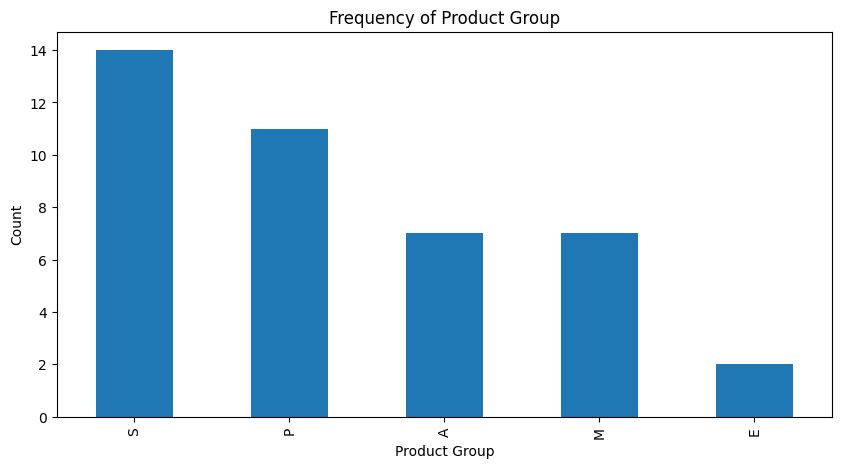

In [10]:
# Plot frequency of Product Group
plt.figure(figsize=(10, 5))
group_counts = node_types['Group'].value_counts()
group_counts.plot(kind='bar')
plt.title('Frequency of Product Group')
plt.xlabel('Product Group')
plt.ylabel('Count')
plt.show()

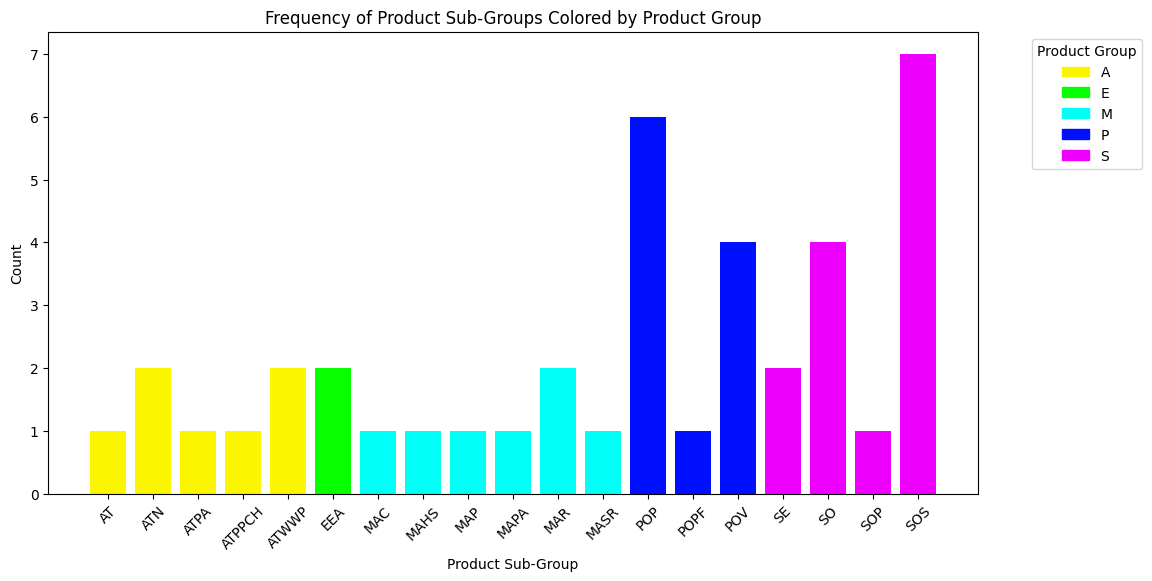

In [11]:
### Plotting the subgroups and color coding based on what group they are in

# Group by Sub-Group and Group to get counts
subgroup_counts = node_types.groupby(['Group', 'Sub-Group']).size().reset_index(name='Count')

# Sort by Group and Sub-Group for better visualization
subgroup_counts = subgroup_counts.sort_values(by=['Group', 'Sub-Group'])

# Generate a color palette for each group
unique_groups = subgroup_counts['Group'].unique()
palette = sns.color_palette("hsv", len(unique_groups))

# Create a dictionary to map each group to a specific color
group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

# Map colors to each subgroup based on their group
subgroup_counts['Color'] = subgroup_counts['Group'].map(group_colors)

# Plotting the Product Sub-Group bar chart
plt.figure(figsize=(12, 6))

# Plot each subgroup with its respective group color
for index, row in subgroup_counts.iterrows():
    plt.bar(row['Sub-Group'], row['Count'], color=row['Color'], label=row['Group'])

# Adding title and labels
plt.title('Frequency of Product Sub-Groups Colored by Product Group')
plt.xlabel('Product Sub-Group')
plt.ylabel('Count')

# Add a legend for group colors
handles = [plt.Rectangle((0, 0), 1, 1, color=group_colors[group]) for group in unique_groups]
plt.legend(handles, unique_groups, title="Product Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.show()



In [12]:
### Exploring the note in the README about some nodes belonging to multiple groups

# Group by Node and count unique groups and sub-groups
multi_type_nodes = node_types.groupby('Node').agg({'Group': 'nunique', 'Sub-Group': 'nunique'})

# Filter nodes that have more than one type
multi_type_nodes = multi_type_nodes[(multi_type_nodes['Group'] > 1) | (multi_type_nodes['Sub-Group'] > 1)]

# my thoughts on this: I don't understand why the README.md in the Nodes folder says
# that one node can have multiple node types when I don't actually see it here
# I think maybe they just gave it a primary node type and didn't give us the additional
# information about the other types that it could be in
print("Nodes with Multiple Node Types:")
print(multi_type_nodes)


Nodes with Multiple Node Types:
Empty DataFrame
Columns: [Group, Sub-Group]
Index: []


Selected Nodes: ['ATN02K12P', 'MAR02K12P', 'SOS003L04P', 'SO0001L12P', 'SE500G24P', 'MAHS025K']


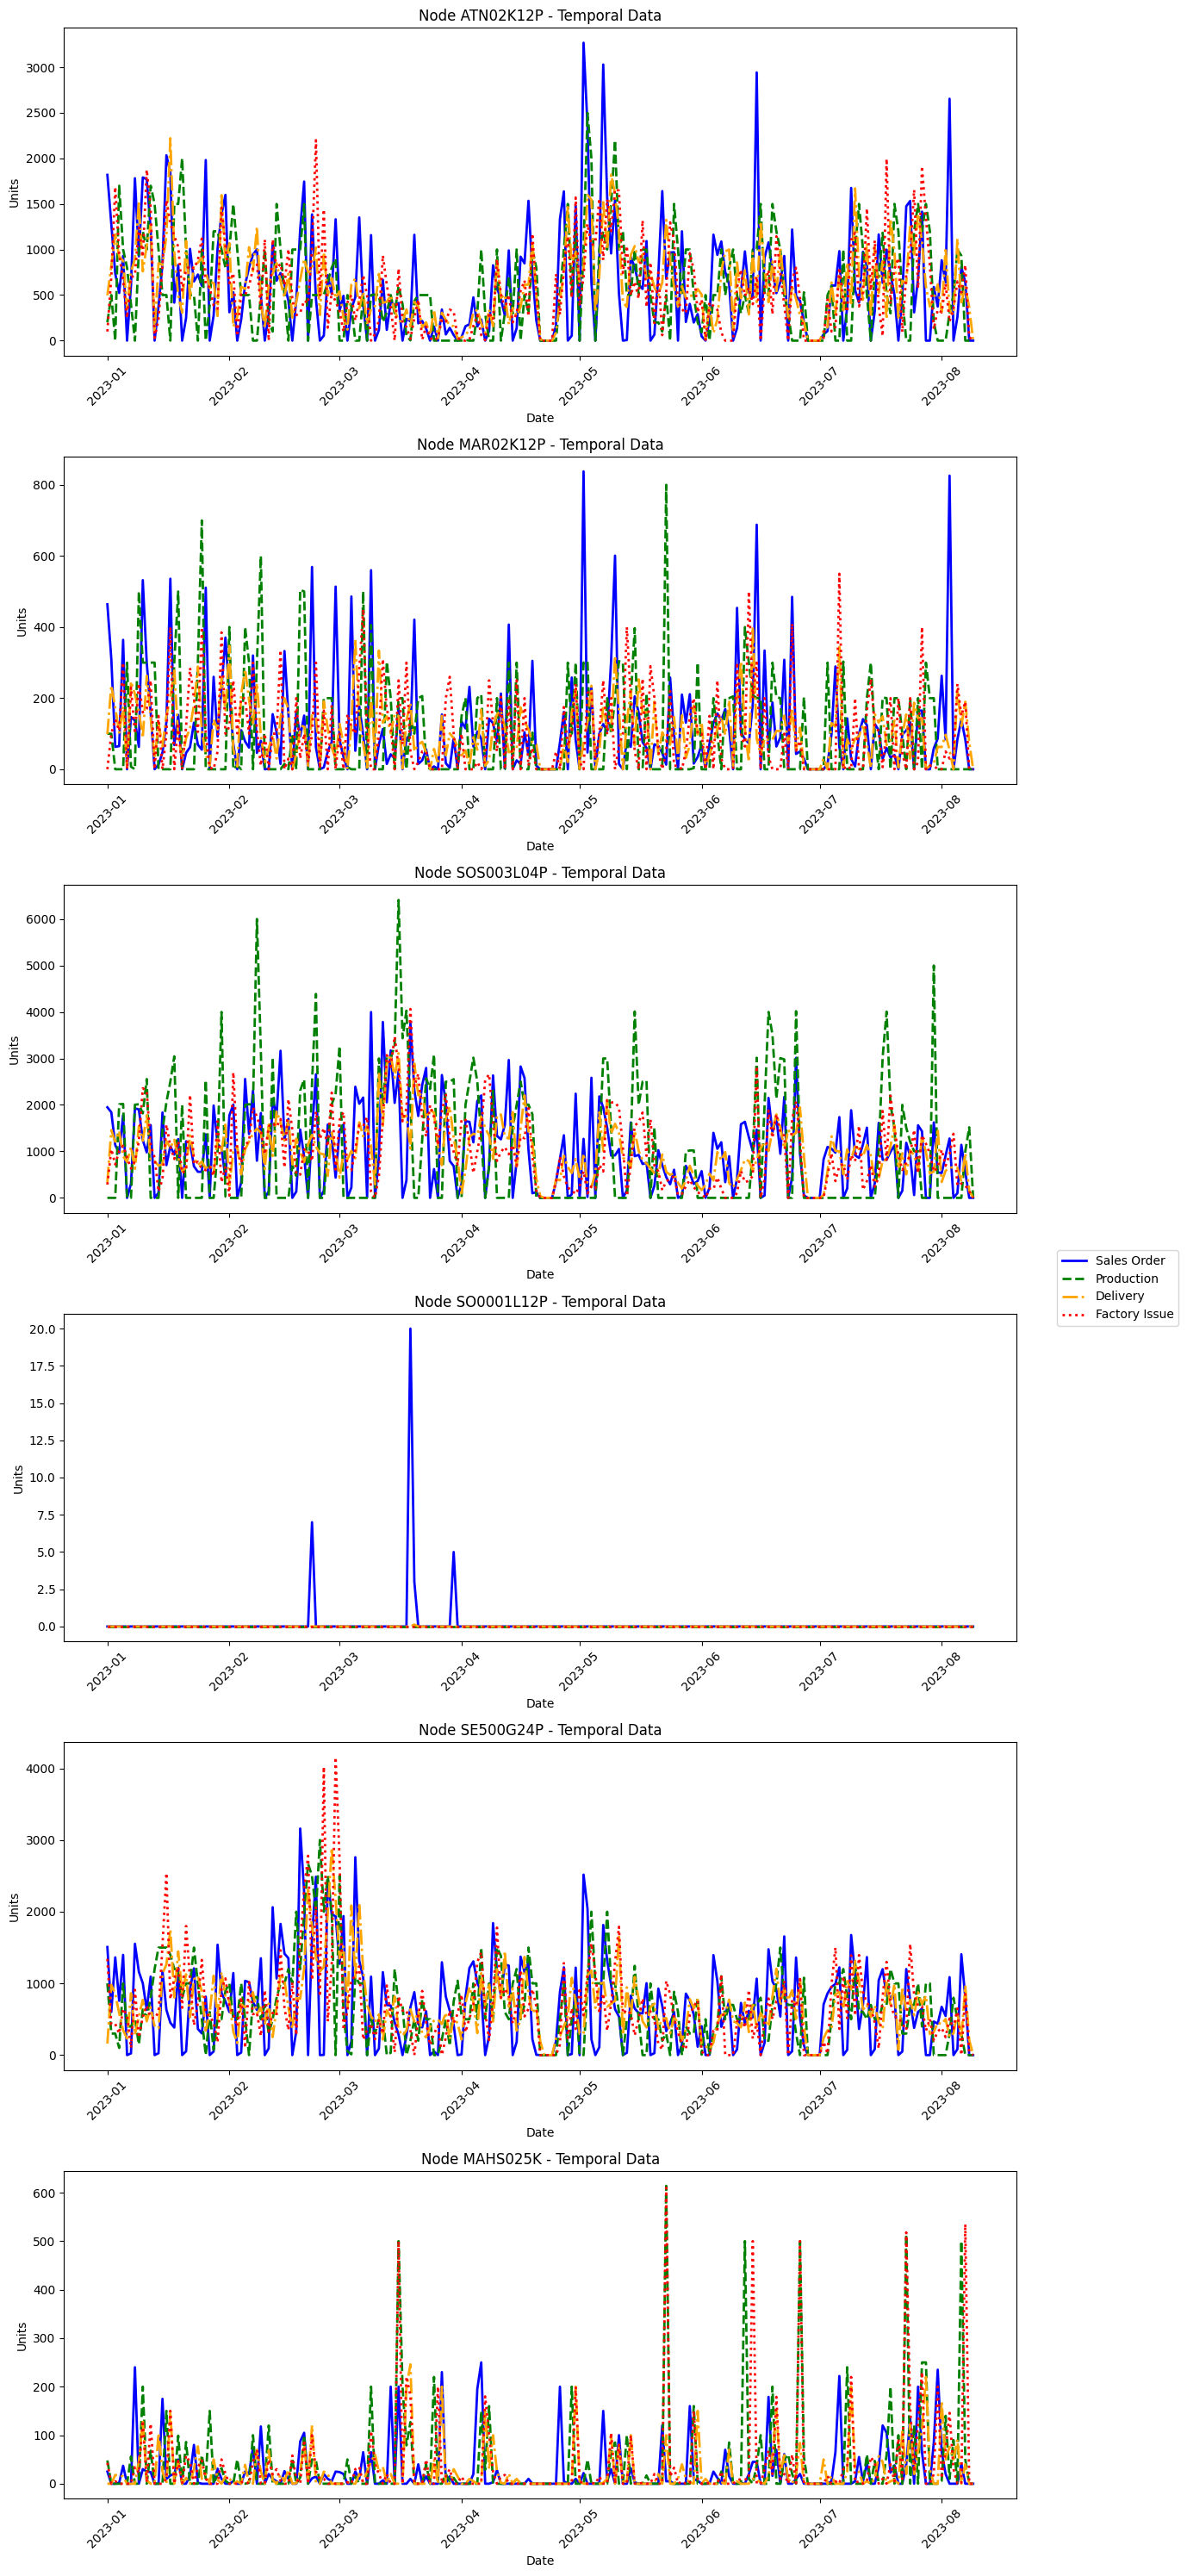

In [13]:
# Set the seed for reproducibility
random.seed(0)


# Extract the date column (leave the original dataframes intact)
dates = pd.to_datetime(sales_order_df['Date'])

# Create separate dataframes without the Date column
sales_order_values = sales_order_df.drop(columns=['Date'])
production_values = production_df.drop(columns=['Date'])
delivery_values = delivery_df.drop(columns=['Date'])
factory_issue_values = factory_issue_df.drop(columns=['Date'])

# Select 6 random nodes
random_nodes = random.sample(list(sales_order_values.columns), 6)
print("Selected Nodes:", random_nodes)

# Create the subplot layout (1 column, 6 rows)
fig, axes = plt.subplots(6, 1, figsize=(12, 30))

# Plot each node's data
for idx, node in enumerate(random_nodes):
    # Plot each metric
    axes[idx].plot(dates, sales_order_values[node], label='Sales Order', color='blue', linestyle='-', linewidth=2)
    axes[idx].plot(dates, production_values[node], label='Production', color='green', linestyle='--', linewidth=2)
    axes[idx].plot(dates, delivery_values[node], label='Delivery', color='orange', linestyle='-.', linewidth=2)
    axes[idx].plot(dates, factory_issue_values[node], label='Factory Issue', color='red', linestyle=':', linewidth=2)

    # Formatting the plot
    axes[idx].set_title(f'Node {node} - Temporal Data')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Units')
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust spacing and add a common legend off the plot
plt.tight_layout()
fig.legend(['Sales Order', 'Production', 'Delivery', 'Factory Issue'], loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.show()


# my analysis of the below 6 random graphs:
# for node MAHS025K - a big spike in production leads to a big spike in delivery
# for node SO0001L12P - this shows that the production and delivery seems
#                        very stable but there are occasional massive sales orders
# for node SE500G24P - it seems like there was a spike in activity around february, maybe slightly seasonal?

In [14]:
node_types['Group'].unique()

array(['S', 'P', 'A', 'M', 'E'], dtype=object)

In [15]:
def plot_group_correlation_heatmaps(group_filter):
    """
    Plots correlation heatmaps for a given product group.

    Parameters:
    - group_filter (str): The product group to visualize (e.g., "A", "S").
    """

    # Create separate DataFrames without the Date column
    sales_order_values = sales_order_df.drop(columns=['Date'])
    production_values = production_df.drop(columns=['Date'])
    delivery_values = delivery_df.drop(columns=['Date'])
    factory_issue_values = factory_issue_df.drop(columns=['Date'])

    # Filter nodes by the selected product group
    nodes_in_group = node_types[node_types['Group'] == group_filter]['Node'].unique()
    if len(nodes_in_group) == 0:
        print(f"No products found for group '{group_filter}'")
        return

    print(f"Products in Product Group '{group_filter}':", nodes_in_group)

    # Compute correlation matrices for each temporal variable
    sales_corr = sales_order_values[nodes_in_group].corr()
    prod_corr = production_values[nodes_in_group].corr()
    deliv_corr = delivery_values[nodes_in_group].corr()
    factory_corr = factory_issue_values[nodes_in_group].corr()

    # Plot heatmaps for each temporal variable in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Sales Order Correlation Heatmap
    sns.heatmap(sales_corr, ax=axes[0, 0], cmap="coolwarm", annot=True, fmt=".2f")
    axes[0, 0].set_title(f"Sales Order Correlation (Group {group_filter})")

    # Production Correlation Heatmap
    sns.heatmap(prod_corr, ax=axes[0, 1], cmap="coolwarm", annot=True, fmt=".2f")
    axes[0, 1].set_title(f"Production Correlation (Group {group_filter})")

    # Delivery Correlation Heatmap
    sns.heatmap(deliv_corr, ax=axes[1, 0], cmap="coolwarm", annot=True, fmt=".2f")
    axes[1, 0].set_title(f"Delivery Correlation (Group {group_filter})")

    # Factory Issue Correlation Heatmap
    sns.heatmap(factory_corr, ax=axes[1, 1], cmap="coolwarm", annot=True, fmt=".2f")
    axes[1, 1].set_title(f"Factory Issue Correlation (Group {group_filter})")

    plt.tight_layout()
    plt.show()

Products in Product Group 'A': ['AT5X5K' 'ATN02K12P' 'ATN01K24P' 'ATWWP002K12P' 'ATWWP001K24P'
 'ATPPCH5X5K' 'ATPA1K24P']


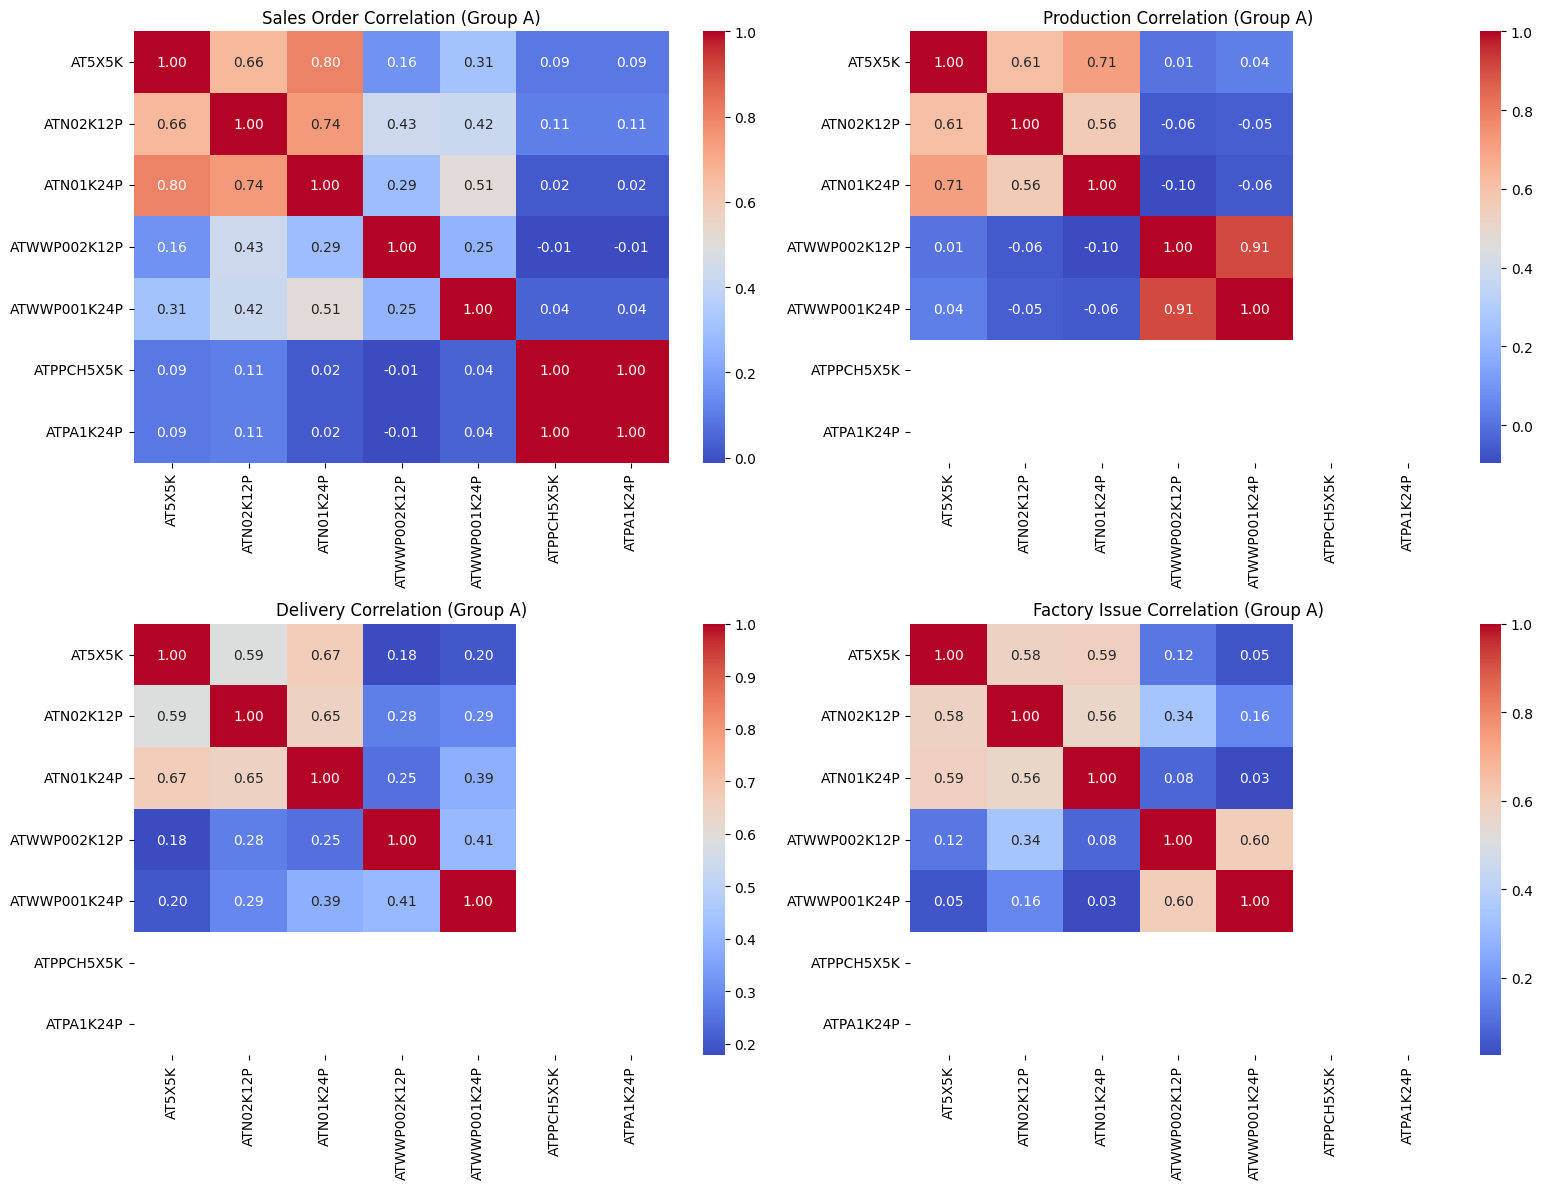

In [16]:
plot_group_correlation_heatmaps("A")

# my analysis of these graphs:
# the first 3 products seem to be pretty correlated with each other for all 4 types
# then the last two products are correlated with each other in sales and production but not in delivery (and moderate factory issue correlation)

Products in Product Group 'S': ['SOS008L02P' 'SOS005L04P' 'SOS003L04P' 'SOS002L09P' 'SOS001L12P'
 'SOS500M24P' 'SOS250M48P' 'SOP001L12P' 'SO0005L04P' 'SO0002L09P'
 'SO0001L12P' 'SO0500M24P' 'SE500G24P' 'SE200G24P']


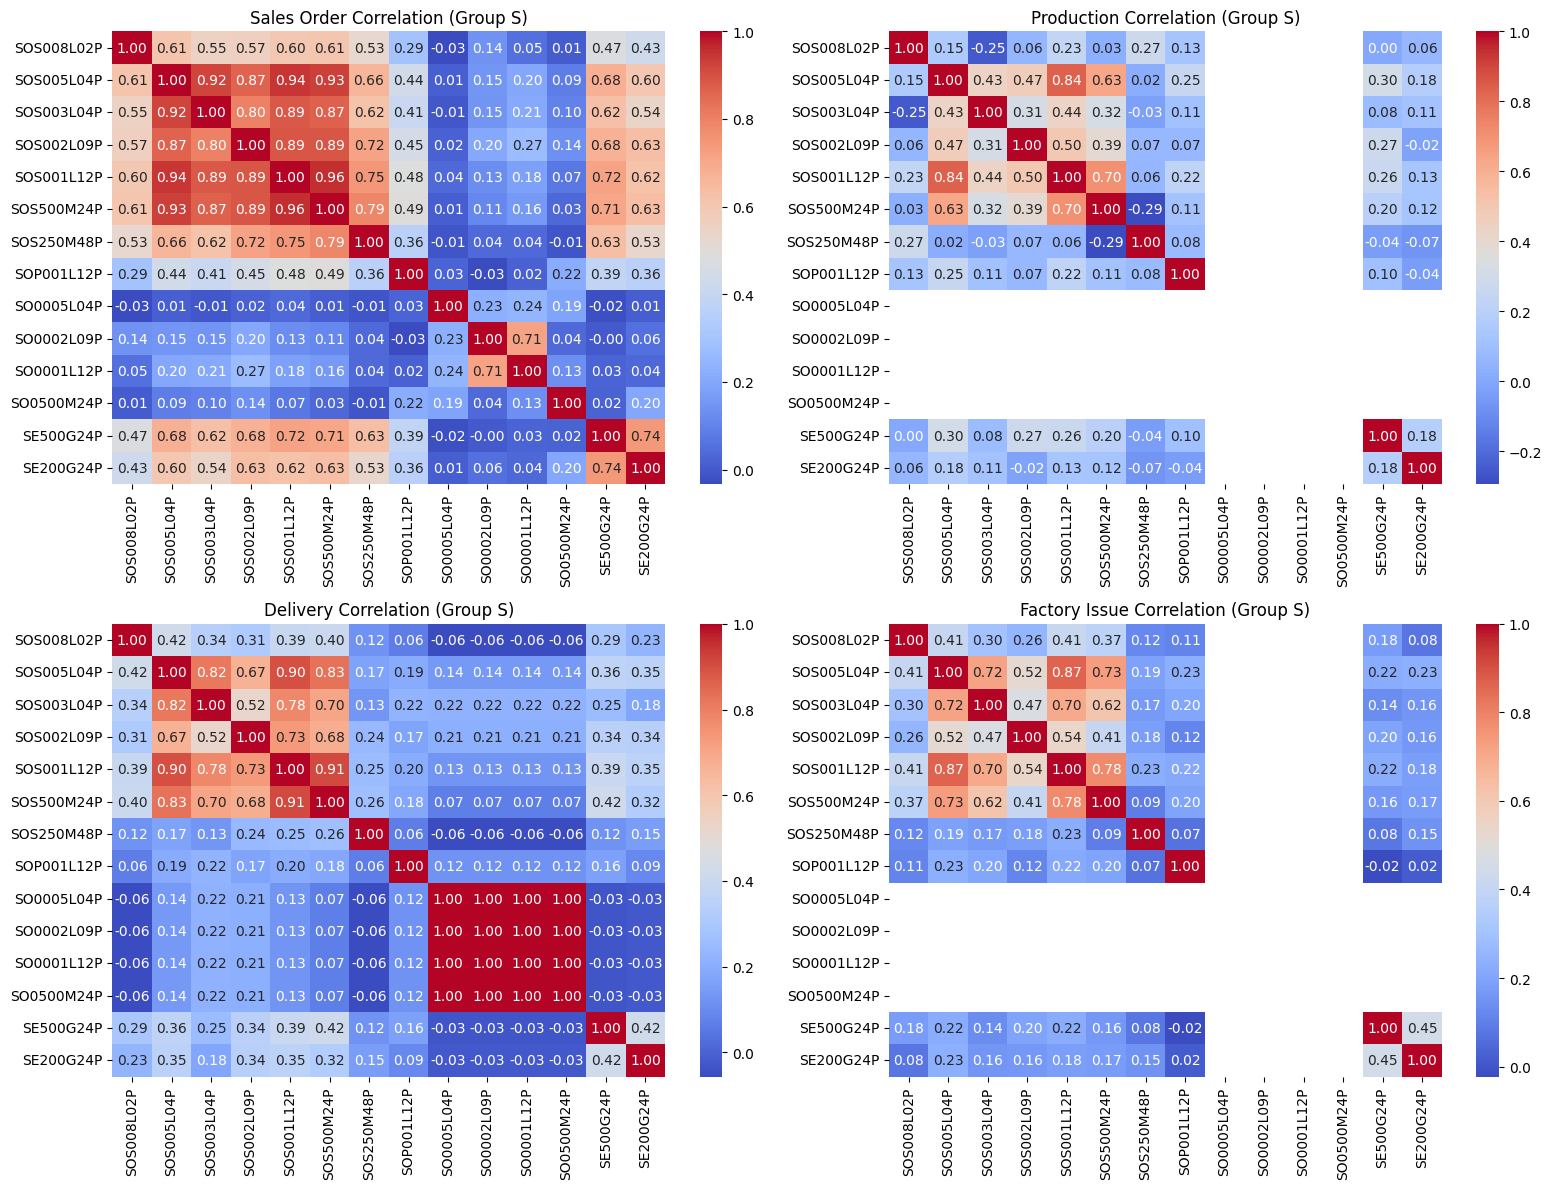

In [17]:
plot_group_correlation_heatmaps("S")

# my analysis: clearly some products within group S are highly correlated in terms of sales and delivery
# but those same products are not necessarily as correlated in production or factory issue
# there are also a lot of nodes that have null values as we can see

# Quality Assurance

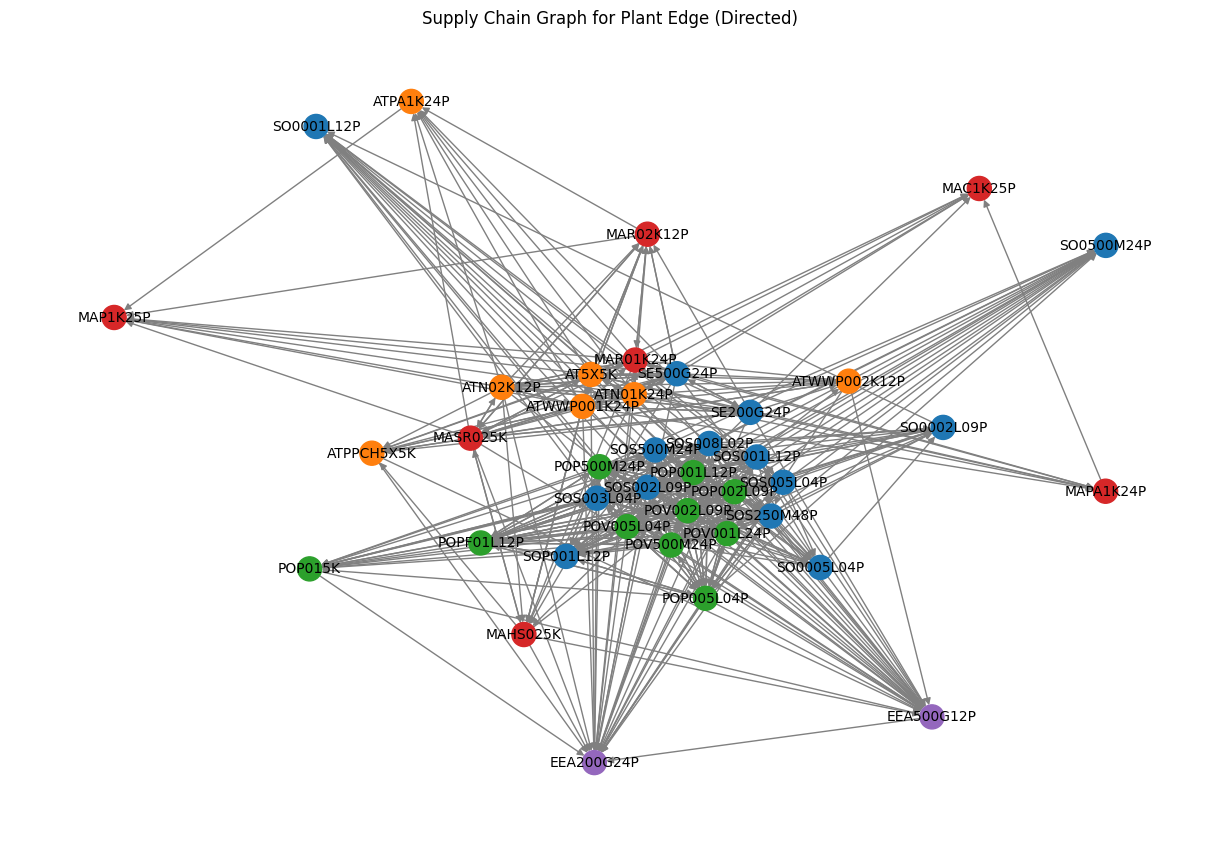

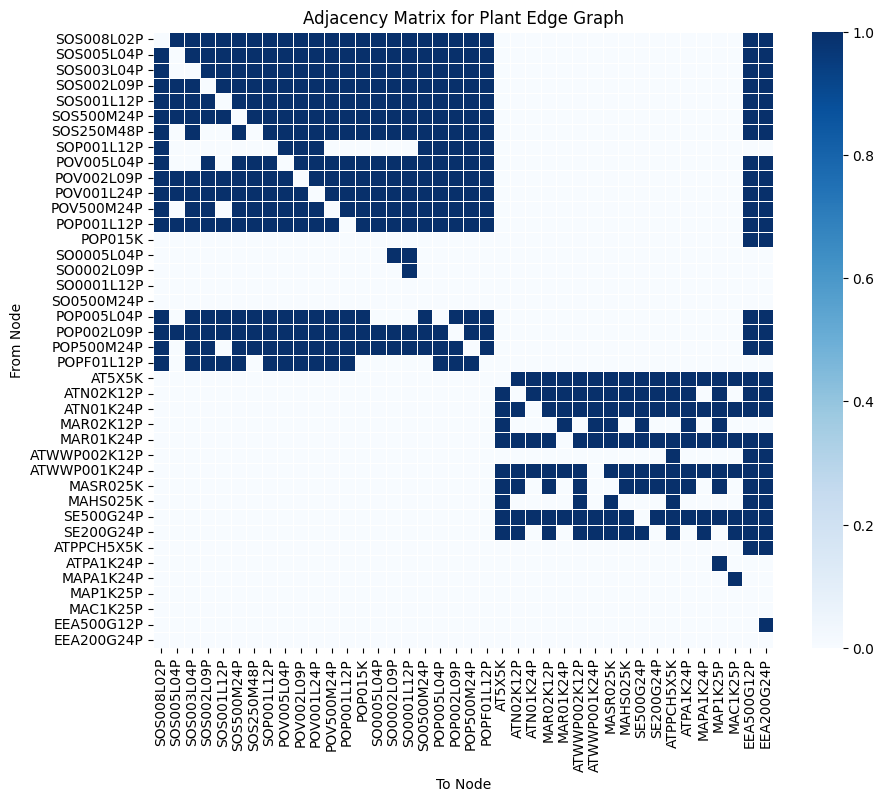

In [18]:
# Create a Directed Graph
G = nx.DiGraph()

# Add nodes from nodes_df
for node in nodes_df['Node']:
    G.add_node(node)

# Add directed edges from plant_edges_df
# Assuming plant_edges_df has columns: ['Plant', 'node1', 'node2']
for idx, row in plant_edges_df.iterrows():
    G.add_edge(row['node1'], row['node2'])

# Color-code Nodes by Product Group
# Create a mapping from Node to its Product Group using node_types DataFrame.
node_group_map = node_types.groupby('Node')['Group'].first().to_dict()

# Get unique groups and assign each a color using a predefined palette.
unique_groups = list(set(node_group_map.values()))
colors = list(mcolors.TABLEAU_COLORS.values())
group_color_map = {group: colors[i % len(colors)] for i, group in enumerate(unique_groups)}

# Assign a color to each node
node_colors = [group_color_map.get(node_group_map.get(node, "Unknown"), "#cccccc") for node in G.nodes()]

# Visualize the Graph Layout with Adjusted Parameters
# Use spring layout with an increased 'k' parameter to reduce overlap.
# Alternatively, try: pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, seed=42, k=1.0)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
        arrows=True, font_size=10)
plt.title("Supply Chain Graph for Plant Edge (Directed)")
plt.show()

# Create and Visualize the Adjacency Matrix
adj_df = nx.to_pandas_adjacency(G, dtype=int)
plt.figure(figsize=(10, 8))
sns.heatmap(adj_df, cmap="Blues", cbar=True, linewidths=0.5)
plt.title("Adjacency Matrix for Plant Edge Graph")
plt.xlabel("To Node")
plt.ylabel("From Node")
plt.show()

# my analysis of the graph
# There is a highly interconnected central core with many nodes tightly clustered
# which indicates that there is a high degree of centrality, where few nodes play
# a crucial role in connecting multiple products
# some nodes are positioned on the pheriphery and connected only to the central cluster,
# they might be specilized or less frequently used products
# the green group appears to be one of the most densely connected so they must be frequently involved in joint production or logistics processes
# the red  shows significant connectivity and appears in the central core
  # perhaps these ones that are red might also be blue, since it was noted in the markdown file that products can have multiple types
# the edges show high density and directionality, which indicate strong interdependencies or cyclic relationships
# nodes with a high degree of connectivity may act as bottlenecks in the supply chain. A disruption in these products could have ripple effects across the network


# Preprocessing

In [19]:
# Check for duplicate nodes
# I'm not sure why a duplicate node is showing up, but I am just going to remove
# it from all of the dataframes because it is showing to be unreliable since it showed up as a duplicate
# I am not sure what caused it to become duplicated, but the safer option is to just remove for now
# but in the future, if I had extra time, I might consider cleaning it so that I can still use it
print("Checking for duplicate nodes in nodes_df...")
duplicate_nodes = nodes_df[nodes_df.duplicated(subset=['Node'], keep=False)]
print(f"Duplicate nodes identified:\n{duplicate_nodes}")

Checking for duplicate nodes in nodes_df...
Duplicate nodes identified:
          Node
12  POP001L12P
20  POP001L12P


In [20]:
# Define the duplicate node to remove
duplicate_node = "POP001L12P"

print(f"\nRemoving duplicate node '{duplicate_node}' from all dataframes...")

# Remove from nodes_df
nodes_df = nodes_df[nodes_df['Node'] != duplicate_node]

# Remove from nodes_index
nodes_index = nodes_index[nodes_index['Node'] != duplicate_node]

# Remove from node_types
node_types = node_types[node_types['Node'] != duplicate_node]

# Remove from plant edges
plant_edges_df = plant_edges_df[~plant_edges_df['node1'].eq(duplicate_node) & ~plant_edges_df['node2'].eq(duplicate_node)]

# Remove from group edges
group_edges_df = group_edges_df[~group_edges_df['node1'].eq(duplicate_node) & ~group_edges_df['node2'].eq(duplicate_node)]

# Remove from temporal dataframes
def remove_duplicate_from_temporal(df, node_name):
    if node_name in df.columns:
        return df.drop(columns=[node_name])
    return df

sales_order_df = remove_duplicate_from_temporal(sales_order_df, duplicate_node)
production_df = remove_duplicate_from_temporal(production_df, duplicate_node)
delivery_df = remove_duplicate_from_temporal(delivery_df, duplicate_node)
factory_issue_df = remove_duplicate_from_temporal(factory_issue_df, duplicate_node)

print("Duplicate node removed from all relevant dataframes.")

# ---------------------------
# Step 2: Summary of Data Cleaning
# ---------------------------
print(f"\nFinal node count after duplicate removal: {len(nodes_df)}")
print(f"Shape of nodes_df: {nodes_df.shape}")
print(f"Shape of nodes_index: {nodes_index.shape}")
print(f"Shape of node_types: {node_types.shape}")
print(f"Shape of plant_edges_df: {plant_edges_df.shape}")
print(f"Shape of group_edges_df: {group_edges_df.shape}")
print(f"Shape of sales_order_df: {sales_order_df.shape}")
print(f"Shape of production_df: {production_df.shape}")
print(f"Shape of delivery_df: {delivery_df.shape}")
print(f"Shape of factory_issue_df: {factory_issue_df.shape}")



Removing duplicate node 'POP001L12P' from all dataframes...
Duplicate node removed from all relevant dataframes.

Final node count after duplicate removal: 39
Shape of nodes_df: (39, 1)
Shape of nodes_index: (39, 2)
Shape of node_types: (39, 3)
Shape of plant_edges_df: (1477, 3)
Shape of group_edges_df: (170, 3)
Shape of sales_order_df: (221, 41)
Shape of production_df: (221, 41)
Shape of delivery_df: (221, 41)
Shape of factory_issue_df: (221, 41)


In [21]:
# Helper function to identify mostly zero nodes
def find_zero_nodes(df, threshold=0.95):
    zero_nodes = []
    for node in df.columns[1:]:  # Skip the 'Date' column
        zero_count = (df[node] == 0).sum()
        zero_ratio = zero_count / len(df)
        if zero_ratio >= threshold:
            zero_nodes.append(node)
    return zero_nodes

# Identify nodes with mostly zero values in each temporal dataframe
zero_nodes_sales = find_zero_nodes(sales_order_df)
zero_nodes_production = find_zero_nodes(production_df)
zero_nodes_delivery = find_zero_nodes(delivery_df)
zero_nodes_factory = find_zero_nodes(factory_issue_df)

# Combine zero nodes from all temporal dataframes
all_zero_nodes = set(zero_nodes_sales + zero_nodes_production + zero_nodes_delivery + zero_nodes_factory)

print(f"Identified nodes with mostly zero values (>= 95% zeros): {all_zero_nodes}")
print(f"Number of nodes to mask out: {len(all_zero_nodes)}")

# ---------------------------
# Step 3: Remove Identified Nodes from All DataFrames
# ---------------------------

# Remove zero nodes from nodes_df
nodes_df = nodes_df[~nodes_df['Node'].isin(all_zero_nodes)]

# Remove zero nodes from nodes_index
nodes_index = nodes_index[~nodes_index['Node'].isin(all_zero_nodes)]

# Remove zero nodes from node_types
node_types = node_types[~node_types['Node'].isin(all_zero_nodes)]

# Remove zero nodes from edges dataframes
plant_edges_df = plant_edges_df[~plant_edges_df['node1'].isin(all_zero_nodes) & ~plant_edges_df['node2'].isin(all_zero_nodes)]
group_edges_df = group_edges_df[~group_edges_df['node1'].isin(all_zero_nodes) & ~group_edges_df['node2'].isin(all_zero_nodes)]

# Remove zero nodes from temporal dataframes
def remove_nodes_from_temporal(df, nodes):
    for node in nodes:
        if node in df.columns:
            df = df.drop(columns=[node])
    return df

sales_order_df = remove_nodes_from_temporal(sales_order_df, all_zero_nodes)
production_df = remove_nodes_from_temporal(production_df, all_zero_nodes)
delivery_df = remove_nodes_from_temporal(delivery_df, all_zero_nodes)
factory_issue_df = remove_nodes_from_temporal(factory_issue_df, all_zero_nodes)

print("\nSuccessfully masked out nodes with mostly zero values.")

# ---------------------------
# Step 4: Summary of Data Cleaning
# ---------------------------
print(f"\nFinal node count after masking zero nodes: {len(nodes_df)}")
print(f"Shape of nodes_df: {nodes_df.shape}")
print(f"Shape of nodes_index: {nodes_index.shape}")
print(f"Shape of node_types: {node_types.shape}")
print(f"Shape of plant_edges_df: {plant_edges_df.shape}")
print(f"Shape of group_edges_df: {group_edges_df.shape}")
print(f"Shape of sales_order_df: {sales_order_df.shape}")
print(f"Shape of production_df: {production_df.shape}")
print(f"Shape of delivery_df: {delivery_df.shape}")
print(f"Shape of factory_issue_df: {factory_issue_df.shape}")

Identified nodes with mostly zero values (>= 95% zeros): {'ATPA1K24P', 'SO0005L04P', 'MAPA1K24P', 'EEA200G24P', 'SO0002L09P', 'ATWWP002K12P', 'POP015K', 'MAP1K25P', 'ATWWP001K24P', 'EEA500G12P', 'SO0500M24P', 'ATPPCH5X5K', 'SO0001L12P'}
Number of nodes to mask out: 13

Successfully masked out nodes with mostly zero values.

Final node count after masking zero nodes: 26
Shape of nodes_df: (26, 1)
Shape of nodes_index: (26, 2)
Shape of node_types: (26, 3)
Shape of plant_edges_df: (1257, 3)
Shape of group_edges_df: (86, 3)
Shape of sales_order_df: (221, 28)
Shape of production_df: (221, 28)
Shape of delivery_df: (221, 28)
Shape of factory_issue_df: (221, 28)


# Preprocessing
### Step 1: Train-Test Split (95:5 Ratio)

1. **Objective:**
   - Split the entire dataset into training and testing subsets.
   - The split ratio is set to **0.95 (95% train, 5% test)** to ensure the training data has sufficient volume.

2. **Implementation Details:**
   - The `split_train_test()` function takes the DataFrame and a ratio as input.
   - Uses integer indexing to determine the split point.
   - Returns two separate DataFrames: training and testing.

3. **Why 95:5 Ratio?**
   - Time-series data often benefits from having more training data to capture patterns and trends.
   - A small test set is sufficient to evaluate generalization, especially when data volume is large.

---

### Step 2: Temporal Normalization (Z-Score Normalization)

1. **Objective:**
   - Normalize the temporal features to have a **mean of 0 and a standard deviation of 1**.
   - This is crucial to avoid biases from varying scales of input features.

2. **Normalization Formula:**
   - Z = (X - μ) / σ
   - Where:
     - X = Original value
     - μ = Mean of the feature
     - σ = Standard deviation of the feature

3. **Implementation Details:**
   - Uses `StandardScaler` from `sklearn.preprocessing` to standardize the data.
   - Applies the scaler independently to each temporal feature.
   - Maintains the `Date` column separately to preserve temporal continuity.

4. **Why Z-Score Normalization?**
   - Ensures that each feature contributes equally during model training.
   - Models like GNNs and LSTMs are sensitive to feature scaling, and normalization helps stabilize the training process.

---

### Step 3: Sequence Construction (Rolling Time Window of Size 5)

1. **Objective:**
   - Construct rolling time window sequences of size 5 for each node.
   - The **next time point** after the window serves as the **label**.

2. **Implementation Details:**
   - Uses a sliding window approach to generate sequences of 5 time steps.
   - The subsequent time point serves as the prediction target (label).
   - The function `create_sequences()` generates both sequences and their corresponding labels.

3. **Why Rolling Window of Size 5?**
   - Shorter windows can capture **local temporal patterns** without overfitting to long-term trends.
   - Empirically, a size of 5 works well for capturing short-term variations while maintaining computational efficiency.

---

### Step 4: Summary and Output

1. **Shape of Output:**
   - The sequences are in the shape `(num_sequences, window_size, num_nodes)`, e.g., `(204, 5, 41)`.
   - Labels are in the shape `(num_sequences, num_nodes)`, e.g., `(204, 41)`.

2. **Why This Preprocessing is Effective:**
   - The combination of **train-test splitting**, **temporal normalization**, and **rolling window sequences** ensures that the data is clean, standardized, and formatted for sequential learning.
   - It enables efficient model training and evaluation, making the process robust for time-series forecasting.

---

### Practical Applications:
1. **GNN Models:** Suitable for integrating temporal and graph-structured data.
2. **LSTM Models:** Ideal for learning from time-dependent patterns.
3. **Forecasting and Demand Prediction:** Utilizes past data to predict future values effectively.

In [22]:
def split_train_test(df, ratio=0.95):
    split_index = int(len(df) * ratio)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    return train_df, test_df

# Apply train-test split to each temporal dataframe
sales_order_train, sales_order_test = split_train_test(sales_order_df)
production_train, production_test = split_train_test(production_df)
delivery_train, delivery_test = split_train_test(delivery_df)
factory_issue_train, factory_issue_test = split_train_test(factory_issue_df)

print(f"Sales Order Train Shape: {sales_order_train.shape}, Test Shape: {sales_order_test.shape}")
print(f"Production Train Shape: {production_train.shape}, Test Shape: {production_test.shape}")
print(f"Delivery Train Shape: {delivery_train.shape}, Test Shape: {delivery_test.shape}")
print(f"Factory Issue Train Shape: {factory_issue_train.shape}, Test Shape: {factory_issue_test.shape}")

# ---------------------------
# Step 2: Temporal Normalization (Z-Score)
# ---------------------------
def z_score_normalization(df):
    scaler = StandardScaler()
    date_col = df['Date']
    values = df.drop(columns=['Date'])
    normalized_values = pd.DataFrame(scaler.fit_transform(values), columns=values.columns)
    normalized_values['Date'] = date_col.reset_index(drop=True)
    return normalized_values

# Normalize all train and test datasets
sales_order_train = z_score_normalization(sales_order_train)
sales_order_test = z_score_normalization(sales_order_test)

production_train = z_score_normalization(production_train)
production_test = z_score_normalization(production_test)

delivery_train = z_score_normalization(delivery_train)
delivery_test = z_score_normalization(delivery_test)

factory_issue_train = z_score_normalization(factory_issue_train)
factory_issue_test = z_score_normalization(factory_issue_test)

print("\nNormalization completed for all dataframes.")

# ---------------------------
# Step 3: Sequence Construction (Rolling Time Window of Size 5)
# ---------------------------
def create_sequences(df, window_size=5):
    sequences = []
    labels = []

    # Drop the 'Date' column for sequence creation
    data = df.drop(columns=['Date']).values

    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]  # The next time point as the label
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

# Construct sequences and labels for each normalized train and test dataframe
sales_order_train_seqs, sales_order_train_labels = create_sequences(sales_order_train)
sales_order_test_seqs, sales_order_test_labels = create_sequences(sales_order_test)

production_train_seqs, production_train_labels = create_sequences(production_train)
production_test_seqs, production_test_labels = create_sequences(production_test)

delivery_train_seqs, delivery_train_labels = create_sequences(delivery_train)
delivery_test_seqs, delivery_test_labels = create_sequences(delivery_test)

factory_issue_train_seqs, factory_issue_train_labels = create_sequences(factory_issue_train)
factory_issue_test_seqs, factory_issue_test_labels = create_sequences(factory_issue_test)

print("\nSequence construction completed.")

# ---------------------------
# Step 4: Summary of Data Preparation
# ---------------------------
print(f"\nSales Order Train Sequences: {sales_order_train_seqs.shape}, Labels: {sales_order_train_labels.shape}")
print(f"Sales Order Test Sequences: {sales_order_test_seqs.shape}, Labels: {sales_order_test_labels.shape}")

print(f"Production Train Sequences: {production_train_seqs.shape}, Labels: {production_train_labels.shape}")
print(f"Production Test Sequences: {production_test_seqs.shape}, Labels: {production_test_labels.shape}")

print(f"Delivery Train Sequences: {delivery_train_seqs.shape}, Labels: {delivery_train_labels.shape}")
print(f"Delivery Test Sequences: {delivery_test_seqs.shape}, Labels: {delivery_test_labels.shape}")

print(f"Factory Issue Train Sequences: {factory_issue_train_seqs.shape}, Labels: {factory_issue_train_labels.shape}")
print(f"Factory Issue Test Sequences: {factory_issue_test_seqs.shape}, Labels: {factory_issue_test_labels.shape}")

Sales Order Train Shape: (209, 28), Test Shape: (12, 28)
Production Train Shape: (209, 28), Test Shape: (12, 28)
Delivery Train Shape: (209, 28), Test Shape: (12, 28)
Factory Issue Train Shape: (209, 28), Test Shape: (12, 28)

Normalization completed for all dataframes.

Sequence construction completed.

Sales Order Train Sequences: (204, 5, 27), Labels: (204, 27)
Sales Order Test Sequences: (7, 5, 27), Labels: (7, 27)
Production Train Sequences: (204, 5, 27), Labels: (204, 27)
Production Test Sequences: (7, 5, 27), Labels: (7, 27)
Delivery Train Sequences: (204, 5, 27), Labels: (204, 27)
Delivery Test Sequences: (7, 5, 27), Labels: (7, 27)
Factory Issue Train Sequences: (204, 5, 27), Labels: (204, 27)
Factory Issue Test Sequences: (7, 5, 27), Labels: (7, 27)


# Model Building

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Epoch [20/200], Train Loss: 1.0006, Test Loss: 1.1207
Epoch [40/200], Train Loss: 0.9060, Test Loss: 1.0294
Epoch [60/200], Train Loss: 0.8351, Test Loss: 0.9388
Epoch [80/200], Train Loss: 0.7087, Test Loss: 0.9279
Epoch [100/200], Train Loss: 0.6784, Test Loss: 0.9937
Epoch [120/200], Train Loss: 0.6767, Test Loss: 1.0990
Epoch [140/200], Train Loss: 0.6666, Test Loss: 1.0868
Epoch [160/200], Train Loss: 0.6382, Test Loss: 1.1221
Epoch [180/200], Train Loss: 0.6249, Test Loss: 1.1081
Epoch [200/200], Train Loss: 0.6179, Test Loss: 1.1356
Demand Prediction Metrics:
Train RMSE: 0.7103, Train MAE: 0.4899
Test RMSE: 1.0657, Test MAE: 0.8429


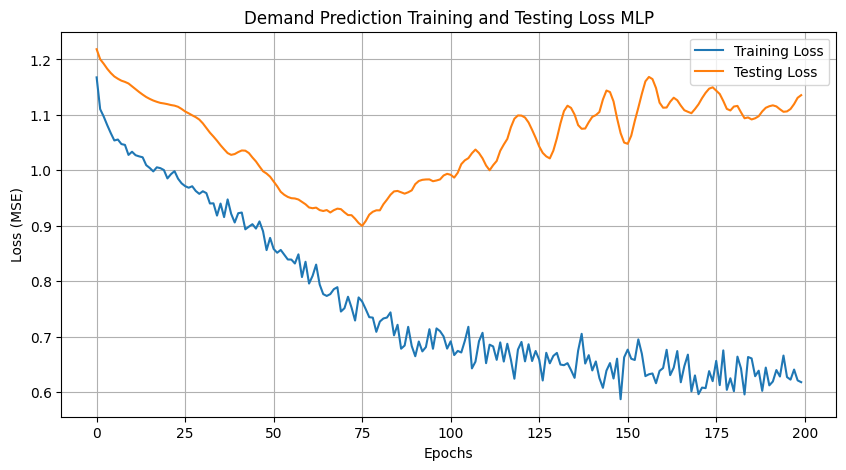

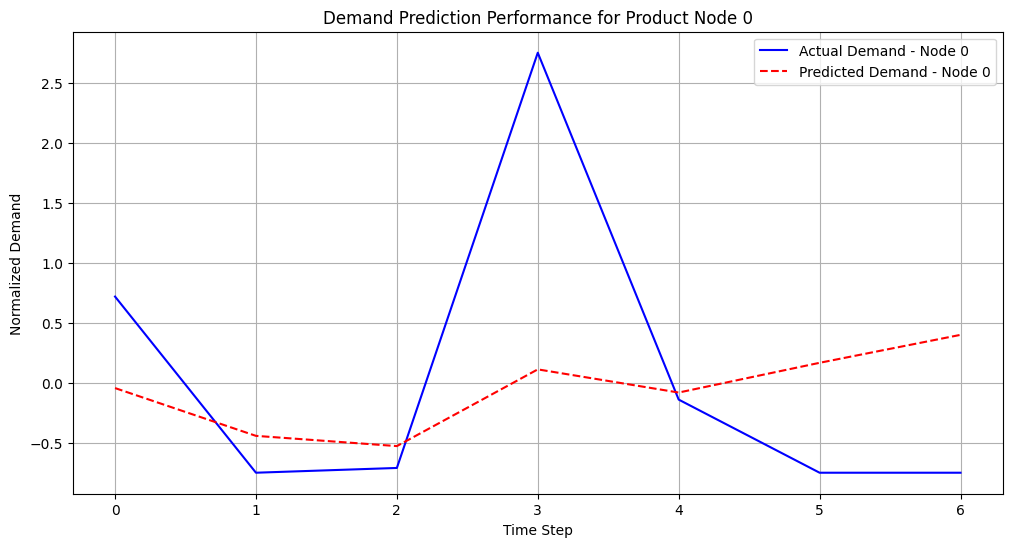

In [ ]:


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Parameters
input_features = 27 * 5  # 27 nodes × 5 time steps
hidden_neurons = 8
output_features = 27
learning_rate = 0.004
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5

# Reshape the sequence data for MLP (batch_size, flattened_sequence)
# Using sales_order data as demand data
X_train = sales_order_train_seqs.reshape(sales_order_train_seqs.shape[0], -1)
y_train = sales_order_train_labels
X_test = sales_order_test_seqs.reshape(sales_order_test_seqs.shape[0], -1)
y_test = sales_order_test_labels

# Convert numpy arrays to torch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Initialize the model
demand_model = MLP(input_features, hidden_neurons, output_features, dropout_rate)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(demand_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    # Training
    demand_model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = demand_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluation
    demand_model.eval()
    with torch.no_grad():
        test_outputs = demand_model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = demand_model.state_dict().copy()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Load best model for final evaluation
if best_model_state:
    demand_model.load_state_dict(best_model_state)

# Evaluate the model
demand_model.eval()
with torch.no_grad():
    final_train_preds = demand_model(X_train_tensor).numpy()
    final_test_preds = demand_model(X_test_tensor).numpy()

# Calculate error metrics for demand prediction
train_rmse = np.sqrt(mean_squared_error(y_train, final_train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, final_test_preds))
train_mae = mean_absolute_error(y_train, final_train_preds)
test_mae = mean_absolute_error(y_test, final_test_preds)

print(f'Demand Prediction Metrics:')
print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Demand Prediction Training and Testing Loss MLP')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions vs actual for a single product node (example: first node)
plt.figure(figsize=(12, 6))
node_idx = 0  # First product node
plt.plot(y_test[:, node_idx], 'b-', label=f'Actual Demand - Node {node_idx}')
plt.plot(final_test_preds[:, node_idx], 'r--', label=f'Predicted Demand - Node {node_idx}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Demand')
plt.title(f'Demand Prediction Performance for Product Node {node_idx}')
plt.legend()
plt.grid(True)
plt.show()

## Graph Convolutional Network (GCN) for Demand Prediction

### Architecture Overview

The GCN model is designed to capture spatial relationships between nodes in a graph for time-series demand prediction.

#### Model Structure
```
GCN(
  (conv1): GCNConv(5 -> 8)
  (conv2): GCNConv(8 -> 1)
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)
```

#### Input Processing
- **Input**: Time series data with shape [num_nodes, seq_length]
  - Each node represents a product/location
  - Each feature represents a time step in the sequence
- **Graph Structure**: Defined by `edge_index` that connects related nodes
  - Combines product group connections and plant-based connections
  - Creates an undirected graph (bidirectional edges)

#### Forward Pass
1. **First GCN Layer**:
   - Applies graph convolution to aggregate information from connected nodes
   - Uses ReLU activation to introduce non-linearity
   - Applies dropout (p=0.5) for regularization

2. **Second GCN Layer**:
   - Maps from hidden dimension (8) to output dimension (1)
   - Produces final prediction for each node

#### Training Details
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam with learning rate 0.0002 and weight decay 5e-4
- **Epochs**: 200 with early stopping based on validation loss
- **Batch Processing**: Each data point is a graph with all nodes

#### Key Advantages
1. **Relational Learning**: Captures dependencies between connected products/locations
2. **Graph Inductive Bias**: Leverages known relationships in supply chain network
3. **Parameter Efficiency**: Fewer parameters than fully-connected alternatives
4. **Spatial-Temporal Modeling**: Combines time series features with graph structure

### Implementation Notes
- Uses PyTorch Geometric's GCNConv implementation
- Prepared for both CPU and GPU execution
- Stores best model based on validation performance

In [25]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda
Epoch [20/200], Train Loss: 0.9629, Test Loss: 0.9089
Epoch [40/200], Train Loss: 0.9006, Test Loss: 0.7558
Epoch [60/200], Train Loss: 0.8527, Test Loss: 0.6869
Epoch [80/200], Train Loss: 0.8300, Test Loss: 0.6588
Epoch [100/200], Train Loss: 0.8332, Test Loss: 0.6480
Epoch [120/200], Train Loss: 0.8236, Test Loss: 0.6433
Epoch [140/200], Train Loss: 0.8095, Test Loss: 0.6442
Epoch [160/200], Train Loss: 0.8255, Test Loss: 0.6450
Epoch [180/200], Train Loss: 0.8172, Test Loss: 0.6432
Epoch [200/200], Train Loss: 0.8137, Test Loss: 0.6409
GCN Demand Prediction Metrics:
Train RMSE: 0.8853, Train MAE: 0.6280
Test RMSE: 0.8005, Test MAE: 0.6151


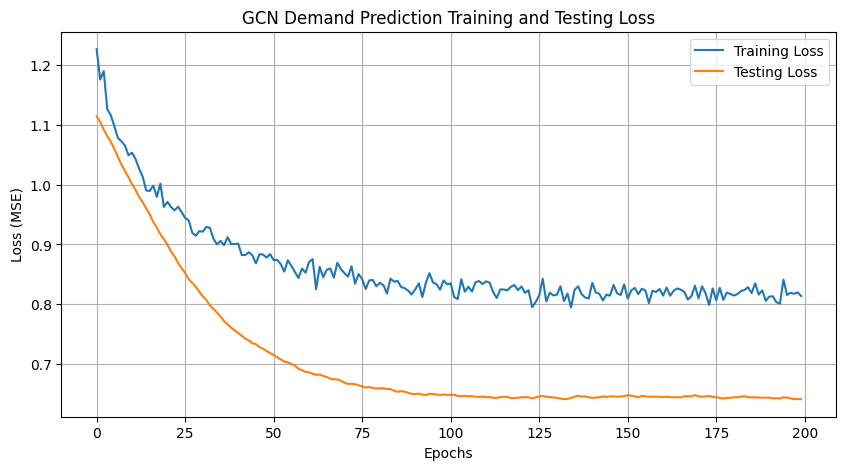

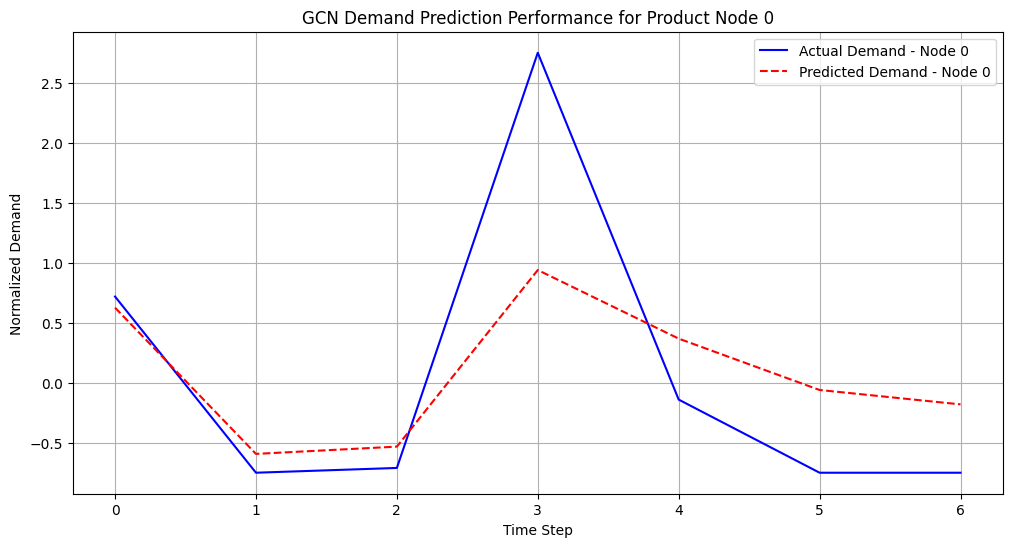

In [26]:


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Output GCN layer
        x = self.conv2(x, edge_index)
        return x

# Parameters
hidden_neurons = 8
num_nodes = 27
seq_length = 5
features_per_node = 1  # Just using sales order data
learning_rate = 0.0002
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5

# Create graph structure from edges
# Combine both plant and product group edges
def prepare_edge_index(plant_edges, group_edges, node_mapping):
    # Extract node pairs from plant edges
    plant_node_pairs = []
    for _, row in plant_edges.iterrows():
        if row['node1'] in node_mapping and row['node2'] in node_mapping:
            node1_idx = node_mapping[row['node1']]
            node2_idx = node_mapping[row['node2']]
            plant_node_pairs.append([node1_idx, node2_idx])
            plant_node_pairs.append([node2_idx, node1_idx])  # Add reverse edge for undirected graph

    # Extract node pairs from group edges
    group_node_pairs = []
    for _, row in group_edges.iterrows():
        if row['node1'] in node_mapping and row['node2'] in node_mapping:
            node1_idx = node_mapping[row['node1']]
            node2_idx = node_mapping[row['node2']]
            group_node_pairs.append([node1_idx, node2_idx])
            group_node_pairs.append([node2_idx, node1_idx])  # Add reverse edge for undirected graph

    # Combine all edges
    all_edges = plant_node_pairs + group_node_pairs

    # Convert to torch tensor with shape [2, num_edges]
    edge_index = torch.tensor(all_edges, dtype=torch.long).t().contiguous().to(device)

    return edge_index

# Create a mapping from node names to indices
node_names = sales_order_df.columns[1:]  # Skip the 'Date' column
node_mapping = {node: idx for idx, node in enumerate(node_names)}

# Prepare edge_index from edge dataframes
edge_index = prepare_edge_index(plant_edges_df, group_edges_df, node_mapping)

# Reshape data for GCN
# We'll use a sliding window approach
def prepare_gcn_data(sequences, labels):
    data_list = []

    for i in range(len(sequences)):
        # Input sequence shape: (seq_length, num_nodes)
        seq = sequences[i]
        label = labels[i]

        # Create time series features for each node
        # We'll create a feature matrix of shape [num_nodes, seq_length]
        x = torch.FloatTensor(seq.transpose(1, 0)).to(device)  # Transpose to shape [num_nodes, seq_length]
        y = torch.FloatTensor(label).to(device)

        # Create PyG data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list

# Prepare GCN data
train_data_list = prepare_gcn_data(sales_order_train_seqs, sales_order_train_labels)
test_data_list = prepare_gcn_data(sales_order_test_seqs, sales_order_test_labels)

# Initialize the model
gcn_model = GCN(input_dim=seq_length, hidden_dim=hidden_neurons, output_dim=1, dropout_rate=dropout_rate).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gcn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    # Training
    gcn_model.train()
    epoch_loss = 0

    for data in train_data_list:
        optimizer.zero_grad()

        # Forward pass
        output = gcn_model(data.x, data.edge_index).squeeze()
        loss = criterion(output, data.y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_data_list)
    train_losses.append(avg_train_loss)

    # Evaluation
    gcn_model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in test_data_list:
            pred = gcn_model(data.x, data.edge_index).squeeze()
            test_loss += criterion(pred, data.y).item()

    avg_test_loss = test_loss / len(test_data_list)
    test_losses.append(avg_test_loss)

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = gcn_model.state_dict().copy()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Load best model for final evaluation
if best_model_state:
    gcn_model.load_state_dict(best_model_state)

# Evaluate the model
gcn_model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for data in train_data_list:
        pred = gcn_model(data.x, data.edge_index).squeeze()
        train_preds.append(pred.cpu().numpy())

    for data in test_data_list:
        pred = gcn_model(data.x, data.edge_index).squeeze()
        test_preds.append(pred.cpu().numpy())

# Convert predictions and ground truth to numpy arrays
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)
train_true = np.array([data.y.cpu().numpy() for data in train_data_list])
test_true = np.array([data.y.cpu().numpy() for data in test_data_list])

# Calculate error metrics
train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
train_mae = mean_absolute_error(train_true, train_preds)
test_mae = mean_absolute_error(test_true, test_preds)

print(f'GCN Demand Prediction Metrics:')
print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('GCN Demand Prediction Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions vs actual for a single product node (example: first node)
plt.figure(figsize=(12, 6))
node_idx = 0  # First product node
plt.plot([y[node_idx] for y in test_true], 'b-', label=f'Actual Demand - Node {node_idx}')
plt.plot([y[node_idx] for y in test_preds], 'r--', label=f'Predicted Demand - Node {node_idx}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Demand')
plt.title(f'GCN Demand Prediction Performance for Product Node {node_idx}')
plt.legend()
plt.grid(True)
plt.show()

## Graph Attention Network (GAT) for Demand Prediction

### Architecture Overview

The GAT model enhances graph neural networks with attention mechanisms to dynamically weight the importance of neighbor nodes.

#### Model Structure
```
GAT(
  (conv1): GATConv(5 -> 4, heads=6)
  (conv2): GATConv(24 -> 1, heads=1)
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)
```

#### Input Processing
- **Input**: Time series data with shape [num_nodes, seq_length]
  - Each node represents a product/location
  - Each feature represents a time step in the sequence
- **Graph Structure**: Defined by `edge_index` connecting related nodes
  - Combines product group connections and plant-based connections
  - Creates an undirected graph (bidirectional edges)

#### Key Components
1. **Multi-head Attention**:
   - Uses 6 attention heads in the first layer
   - Each head computes attention weights independently
   - Allows the model to focus on different aspects of the neighborhood

2. **Forward Pass**:
   - **First GAT Layer**:
     - Applies attention mechanism to weight neighboring nodes
     - Each of the 6 heads produces 4 features (24 total)
     - Applies ReLU activation and dropout (p=0.5)
   
   - **Second GAT Layer**:
     - Combines all heads' outputs into a single output feature
     - `concat=False` ensures outputs are averaged rather than concatenated
     - Produces final prediction for each node

#### Training Details
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam with learning rate 0.00007 and weight decay 5e-4
- **Epochs**: 200 with early stopping based on validation loss
- **Regularization**: Dropout with rate 0.5

#### Advantages Over GCN
1. **Adaptive Node Weighting**: Dynamically focuses on more relevant neighbors
2. **Edge Importance**: Learns importance of connections rather than treating all equally
3. **Multi-aspect Learning**: Multiple attention heads capture different relationship patterns
4. **Better Inductive Bias**: Attention mechanism allows more flexible pattern recognition


In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda
Epoch [20/200], Train Loss: 0.9511, Test Loss: 1.0606
Epoch [40/200], Train Loss: 0.8965, Test Loss: 0.8321
Epoch [60/200], Train Loss: 0.8694, Test Loss: 0.7620
Epoch [80/200], Train Loss: 0.8303, Test Loss: 0.7324
Epoch [100/200], Train Loss: 0.8319, Test Loss: 0.7201
Epoch [120/200], Train Loss: 0.8234, Test Loss: 0.7090
Epoch [140/200], Train Loss: 0.8113, Test Loss: 0.7056
Epoch [160/200], Train Loss: 0.7930, Test Loss: 0.6972
Epoch [180/200], Train Loss: 0.7901, Test Loss: 0.6930
Epoch [200/200], Train Loss: 0.7919, Test Loss: 0.6892
GAT Demand Prediction Metrics:
Train RMSE: 0.8741, Train MAE: 0.6253
Test RMSE: 0.8302, Test MAE: 0.6496


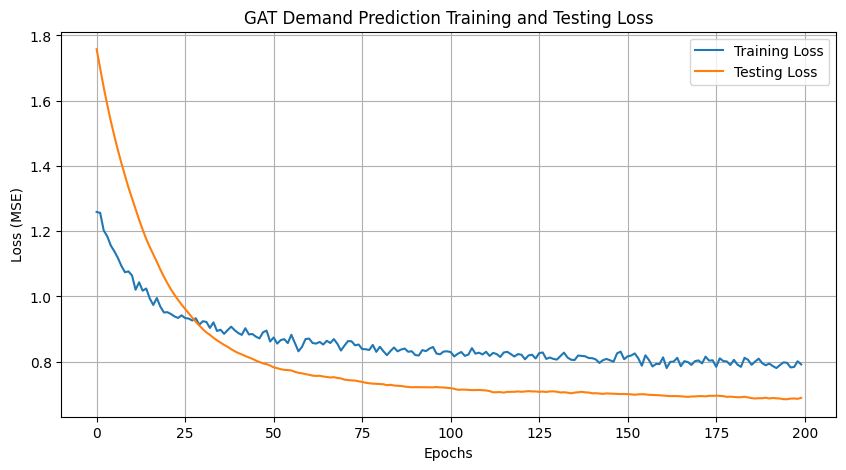

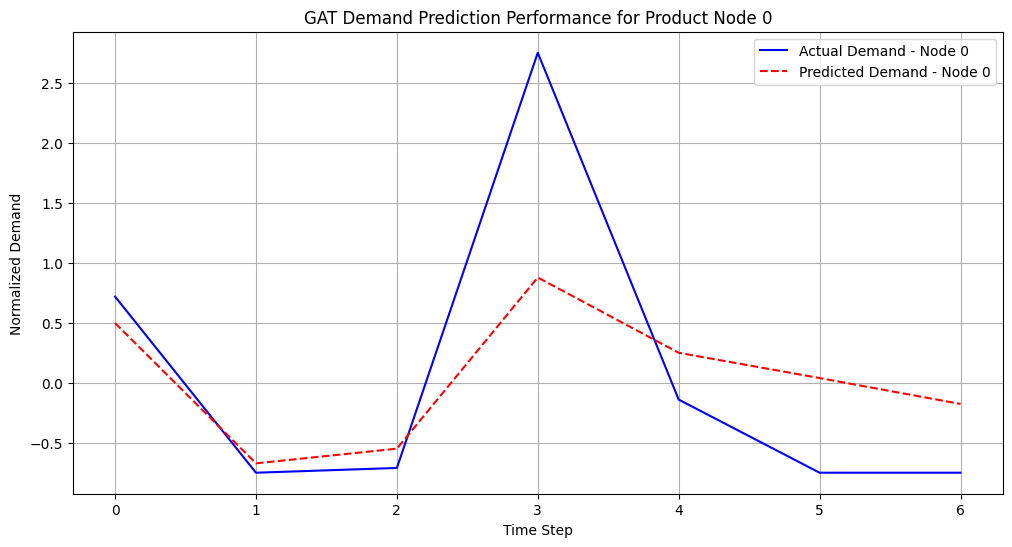

In [ ]:


# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the GAT model
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=6, dropout_rate=0.5):
        super(GAT, self).__init__()
        # GAT layer with multi-head attention (4 neurons x 6 heads = 24 total)
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        # Output layer (combines all heads)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # First GAT layer with multi-head attention
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Output GAT layer
        x = self.conv2(x, edge_index)
        return x

# Parameters as specified
hidden_neurons = 4  # 4 neurons per attention head
attention_heads = 6  # 6 attention heads
num_nodes = 27
seq_length = 5
features_per_node = 1  # Just using sales order data
learning_rate = 0.00007
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5

# Use the same edge_index and data preparation as in the GCN model
# Reusing the prepare_edge_index and prepare_gcn_data functions

# Move edge_index to GPU
edge_index = edge_index.to(device)

# Move data to GPU - assuming train_data_list and test_data_list are already created
for data in train_data_list:
    data.x = data.x.to(device)
    data.y = data.y.to(device)
    data.edge_index = data.edge_index.to(device)

for data in test_data_list:
    data.x = data.x.to(device)
    data.y = data.y.to(device)
    data.edge_index = data.edge_index.to(device)

# Initialize the model and move to GPU
gat_model = GAT(
    input_dim=seq_length,
    hidden_dim=hidden_neurons,
    output_dim=1,
    heads=attention_heads,
    dropout_rate=dropout_rate
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gat_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    # Training
    gat_model.train()
    epoch_loss = 0

    for data in train_data_list:
        optimizer.zero_grad()

        # Forward pass
        output = gat_model(data.x, data.edge_index).squeeze()
        loss = criterion(output, data.y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_data_list)
    train_losses.append(avg_train_loss)

    # Evaluation
    gat_model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in test_data_list:
            pred = gat_model(data.x, data.edge_index).squeeze()
            test_loss += criterion(pred, data.y).item()

    avg_test_loss = test_loss / len(test_data_list)
    test_losses.append(avg_test_loss)

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = gat_model.state_dict().copy()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Load best model for final evaluation
if best_model_state:
    gat_model.load_state_dict(best_model_state)

# Evaluate the model
gat_model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for data in train_data_list:
        pred = gat_model(data.x, data.edge_index).squeeze()
        train_preds.append(pred.cpu().numpy())  # Move predictions back to CPU for numpy conversion

    for data in test_data_list:
        pred = gat_model(data.x, data.edge_index).squeeze()
        test_preds.append(pred.cpu().numpy())  # Move predictions back to CPU for numpy conversion

# Convert predictions and ground truth to numpy arrays
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)
train_true = np.array([data.y.cpu().numpy() for data in train_data_list])  # Move to CPU first
test_true = np.array([data.y.cpu().numpy() for data in test_data_list])  # Move to CPU first

# Calculate error metrics
train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
train_mae = mean_absolute_error(train_true, train_preds)
test_mae = mean_absolute_error(test_true, test_preds)

print(f'GAT Demand Prediction Metrics:')
print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('GAT Demand Prediction Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions vs actual for a single product node
plt.figure(figsize=(12, 6))
node_idx = 0  # First product node
plt.plot([y[node_idx] for y in test_true], 'b-', label=f'Actual Demand - Node {node_idx}')
plt.plot([y[node_idx] for y in test_preds], 'r--', label=f'Predicted Demand - Node {node_idx}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Demand')
plt.title(f'GAT Demand Prediction Performance for Product Node {node_idx}')
plt.legend()
plt.grid(True)
plt.show()

## Temporal Graph Attention Network (TGAT) for Demand Prediction

### Architecture Overview

The TGAT model extends GAT by explicitly modeling the temporal dimension, creating a sophisticated architecture
that captures both spatial relationships between nodes and temporal patterns in sequence data.

#### Model Structure
```
TGAT(
  (time_encoder): Linear(1 -> 8)
  (feature_encoder): Linear(1 -> 8)
  (gat1): GATConv(8 -> 8, heads=6)
  (gat2): GATConv(48 -> 1, heads=1)
  (temporal_attention): Parameter(shape=[5])
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)
```

#### Input Processing
- **Input**: 3D tensor with shape [batch_size, num_nodes, seq_length]
  - Each batch represents a separate time window
  - Each node represents a product/location
  - Each feature represents a time step in the sequence
- **Graph Structure**: Defined by `edge_index` connecting related nodes

#### Key Components

1. **Temporal Encoding**:
   - Each time step is encoded into a hidden dimension using `time_encoder`
   - Creates unique embedding for each position in the sequence

2. **Feature Encoding**:
   - Node features at each time step are encoded using `feature_encoder`
   - Maps raw values to the same hidden dimension as temporal encodings

3. **Time-Node Integration**:
   - For each time step, node features are enhanced with temporal embeddings
   - Adds time-sensitivity to node representations

4. **Graph Attention Processing**:
   - Each time step's enhanced features are processed through GAT layers
   - Multi-head attention (6 heads) captures various aspects of node relationships

5. **Temporal Attention Mechanism**:
   - Learnable weights for each time step (`temporal_attention`)
   - Applies softmax to weight importance of different time steps
   - Performs weighted combination of GAT outputs across time

6. **Final Prediction**:
   - Second GAT layer produces final node predictions
   - Reshaped to match expected output dimensions

#### Data Flow
1. Input sequence → Split into time steps
2. Each time step encoded separately with temporal position information
3. GAT processes each time step's node features
4. Temporal attention combines time step representations
5. Final GAT layer produces predictions for each node

#### Training Details
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam with learning rate 0.005 and weight decay 5e-4
- **Epochs**: 200 with early stopping based on validation loss

#### Advantages Over Standard GAT
1. **Explicit Temporal Modeling**: Handles time dimension directly
2. **Time-Sensitive Attention**: Different weights for different time points
3. **Temporal-Spatial Integration**: Combines time and graph structure together
4. **Flexible Temporal Importance**: Learns which time steps are more relevant

In [29]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda
Epoch [20/200], Train Loss: 0.9585, Test Loss: 1.0489
Epoch [40/200], Train Loss: 0.9326, Test Loss: 0.9877
Epoch [60/200], Train Loss: 0.9111, Test Loss: 0.9477
Epoch [80/200], Train Loss: 0.9020, Test Loss: 0.9154
Epoch [100/200], Train Loss: 0.8891, Test Loss: 0.8997
Epoch [120/200], Train Loss: 0.9031, Test Loss: 0.8812
Epoch [140/200], Train Loss: 0.8954, Test Loss: 0.8604
Epoch [160/200], Train Loss: 0.9001, Test Loss: 0.8681
Epoch [180/200], Train Loss: 0.8800, Test Loss: 0.8500
Epoch [200/200], Train Loss: 0.8806, Test Loss: 0.8457
TGAT Demand Prediction Metrics:
Train RMSE: 0.9319, Train MAE: 0.6787
Test RMSE: 0.9196, Test MAE: 0.7326


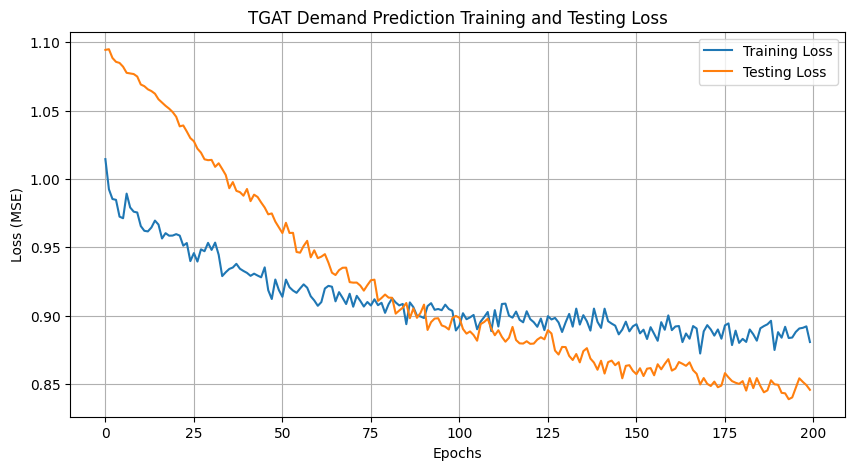

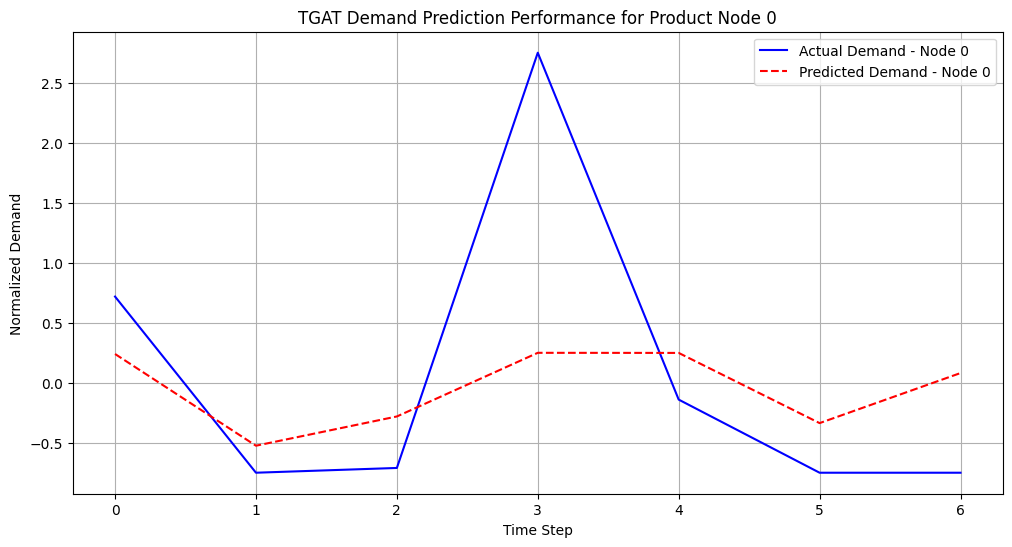

In [30]:


# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the Temporal Graph Attention Network (TGAT) model
class TGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_steps, output_dim, heads=6, dropout_rate=0.5):
        super(TGAT, self).__init__()
        # Temporal embedding layer
        self.time_encoder = nn.Linear(1, hidden_dim)

        # Node feature encoder
        self.feature_encoder = nn.Linear(input_dim, hidden_dim)

        # GAT layers
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

        # Temporal attention (attention over time steps)
        self.temporal_attention = nn.Parameter(torch.ones(time_steps))

        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.heads = heads

    def forward(self, x, edge_index, time_idx=None):
        batch_size, num_nodes, features = x.size()

        # Create temporal embeddings
        if time_idx is None:
            time_idx = torch.arange(self.time_steps, device=x.device).float().view(-1, 1)
        time_embeddings = self.time_encoder(time_idx)  # [time_steps, hidden_dim]

        # Process each time step
        temporal_outputs = []
        for t in range(self.time_steps):
            # Get node features at time step t
            node_feats = x[:, :, t].reshape(-1, 1)  # [batch_size * num_nodes, 1]

            # Encode node features
            node_embeddings = self.feature_encoder(node_feats)  # [batch_size * num_nodes, hidden_dim]

            # Add temporal information
            time_embed = time_embeddings[t].expand(node_embeddings.size())
            node_time_embeddings = node_embeddings + time_embed

            # Apply first GAT layer
            h = self.gat1(node_time_embeddings, edge_index)
            h = self.relu(h)
            h = self.dropout(h)

            # Store output for this time step
            temporal_outputs.append(h)

        # Apply temporal attention - simplified to avoid dimension mismatch
        temporal_weights = F.softmax(self.temporal_attention, dim=0)  # [time_steps]

        # Weighted sum of temporal embeddings
        combined_h = torch.zeros_like(temporal_outputs[0])
        for t in range(self.time_steps):
            combined_h += temporal_outputs[t] * temporal_weights[t]

        # Apply final GAT layer
        out = self.gat2(combined_h, edge_index)

        return out.view(batch_size, num_nodes, -1)

# Parameters
hidden_neurons = 8
attention_heads = 6
num_nodes = 27
seq_length = 5
learning_rate = 0.001
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5

# Prepare data for TGAT (need to reshape compared to GAT/GCN)
def prepare_tgat_data(sequences, labels, edge_index):
    data_list = []

    batch_size = sequences.shape[0]
    num_nodes = sequences.shape[2]
    seq_len = sequences.shape[1]

    # Reshape sequences to [batch_size, num_nodes, seq_len] and move to GPU
    sequences_reshaped = torch.FloatTensor(sequences.transpose(0, 2, 1)).to(device)
    labels_reshaped = torch.FloatTensor(labels).to(device)

    # Create a list of data objects, one for each batch
    for i in range(batch_size):
        data = Data(
            x=sequences_reshaped[i:i+1],  # Shape [1, num_nodes, seq_len]
            edge_index=edge_index,
            y=labels_reshaped[i]
        )
        data_list.append(data)

    return data_list

# Move edge_index to GPU
edge_index = edge_index.to(device)

# Prepare TGAT data
train_data_list = prepare_tgat_data(sales_order_train_seqs, sales_order_train_labels, edge_index)
test_data_list = prepare_tgat_data(sales_order_test_seqs, sales_order_test_labels, edge_index)

# Initialize the model and move to GPU
tgat_model = TGAT(
    input_dim=1,  # Single feature per node per time step
    hidden_dim=hidden_neurons,
    time_steps=seq_length,
    output_dim=1,
    heads=attention_heads,
    dropout_rate=dropout_rate
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tgat_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    # Training
    tgat_model.train()
    epoch_loss = 0

    for data in train_data_list:
        optimizer.zero_grad()

        # Forward pass
        output = tgat_model(data.x, data.edge_index).squeeze()
        loss = criterion(output, data.y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_data_list)
    train_losses.append(avg_train_loss)

    # Evaluation
    tgat_model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in test_data_list:
            pred = tgat_model(data.x, data.edge_index).squeeze()
            test_loss += criterion(pred, data.y).item()

    avg_test_loss = test_loss / len(test_data_list)
    test_losses.append(avg_test_loss)

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = tgat_model.state_dict().copy()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Load best model for final evaluation
if best_model_state:
    tgat_model.load_state_dict(best_model_state)

# Evaluate the model
tgat_model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for data in train_data_list:
        pred = tgat_model(data.x, data.edge_index).squeeze()
        train_preds.append(pred.cpu().numpy())  # Move predictions back to CPU for numpy conversion

    for data in test_data_list:
        pred = tgat_model(data.x, data.edge_index).squeeze()
        test_preds.append(pred.cpu().numpy())  # Move predictions back to CPU for numpy conversion

# Convert predictions and ground truth to numpy arrays
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)
train_true = np.array([data.y.cpu().numpy() for data in train_data_list])  # Move to CPU first
test_true = np.array([data.y.cpu().numpy() for data in test_data_list])  # Move to CPU first

# Calculate error metrics
train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
train_mae = mean_absolute_error(train_true, train_preds)
test_mae = mean_absolute_error(test_true, test_preds)

print(f'TGAT Demand Prediction Metrics:')
print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('TGAT Demand Prediction Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions vs actual for a single product node
plt.figure(figsize=(12, 6))
node_idx = 0  # First product node
plt.plot([y[node_idx] for y in test_true], 'b-', label=f'Actual Demand - Node {node_idx}')
plt.plot([y[node_idx] for y in test_preds], 'r--', label=f'Predicted Demand - Node {node_idx}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Demand')
plt.title(f'TGAT Demand Prediction Performance for Product Node {node_idx}')
plt.legend()
plt.grid(True)
plt.show()

# TGFormer (Transformer-based Graph Neural Network) for Demand Prediction

## Architecture Overview

The TGFormer combines Transformer architecture with graph neural networks, leveraging self-attention
mechanisms to capture complex relationships between nodes in the supply chain network.

### Model Structure
```
TGFormer(
  (linear1): Linear(5 -> 16)
  (transformer_conv1): TransformerConv(16 -> 16, heads=4)
  (transformer_conv2): TransformerConv(64 -> 1, heads=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5)
)
```

### Input Processing
- **Input**: Time series data with shape [num_nodes, seq_length]
  - Each node represents a product/location
  - Each feature represents a time step in the sequence
- **Graph Structure**: Defined by `edge_index` connecting related nodes

### Key Components

1. **Feature Embedding Layer**:
   - Initial linear projection maps time series features (seq_length=5) to hidden dimension (16)
   - Creates richer representation before graph processing

2. **Transformer-based Graph Convolution**:
   - Uses TransformerConv from PyTorch Geometric
   - Incorporates self-attention mechanisms from Transformer architecture
   - Attention computed over the neighborhood of each node

3. **Multi-head Attention**:
   - First layer uses 4 attention heads (16 features each = 64 total)
   - Each head can focus on different aspects of the neighborhood relations
   - Heads are concatenated to form a rich representation

4. **Forward Pass**:
   - Input features → Linear embedding → ReLU activation
   - First TransformerConv with multi-head attention → ReLU → Dropout
   - Second TransformerConv layer for final prediction

### How TransformerConv Works

1. **Query-Key-Value Mechanism**:
   - For each node, creates query, key, and value projections
   - Attention computed between each node and its neighbors

2. **Self-Attention Computation**:
   - Attention scores = softmax(query · key^T / sqrt(dim))
   - Weighted values = attention scores · values

3. **Edge-Aware Attention**:
   - Unlike standard Transformers, attention is only computed along edges
   - Preserves the graph structure while allowing flexible weighting

### Comparison with Other Models

| Feature | TGFormer | GCN | GAT | TGAT |
|---------|----------|-----|-----|------|
| Attention mechanism | Transformer-based | None | Additive | Dual (graph+time) |
| Parameter efficiency | Medium | High | Medium | Low |
| Feature interaction | Multi-head self-attention | Fixed weights | Dynamic weights | Temporal+spatial |
| Theoretical receptive field | Local neighborhood | Local neighborhood | Local neighborhood | Local+temporal |
| Input dimension handling | Direct embedding | Direct | Direct | Separate encoders |

### Training Details
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam with learning rate 0.0005 and weight decay 5e-4
- **Epochs**: 200 with early stopping based on validation loss
- **Regularization**: Dropout with rate 0.5

### Advantages
1. **Powerful Attention**: Transformer-style attention captures complex node relationships
2. **Multi-aspect Learning**: Multiple attention heads model different relationship patterns
3. **Feature Transformation**: Initial embedding layer enriches node representations
4. **Flexible Architecture**: Can be adapted for different graph structures and features
"""

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Epoch [20/200], Train Loss: 0.7381, Test Loss: 0.6281
Epoch [40/200], Train Loss: 0.6931, Test Loss: 0.6405
Epoch [60/200], Train Loss: 0.6459, Test Loss: 0.6323
Epoch [80/200], Train Loss: 0.6252, Test Loss: 0.6176
Epoch [100/200], Train Loss: 0.6032, Test Loss: 0.6013
Epoch [120/200], Train Loss: 0.5873, Test Loss: 0.6158
Epoch [140/200], Train Loss: 0.5825, Test Loss: 0.6223
Epoch [160/200], Train Loss: 0.5531, Test Loss: 0.6292
Epoch [180/200], Train Loss: 0.5505, Test Loss: 0.6730
Epoch [200/200], Train Loss: 0.5345, Test Loss: 0.6558
TGFormer Demand Prediction Metrics:
Train RMSE: 0.7084, Train MAE: 0.4759
Test RMSE: 0.8098, Test MAE: 0.6122


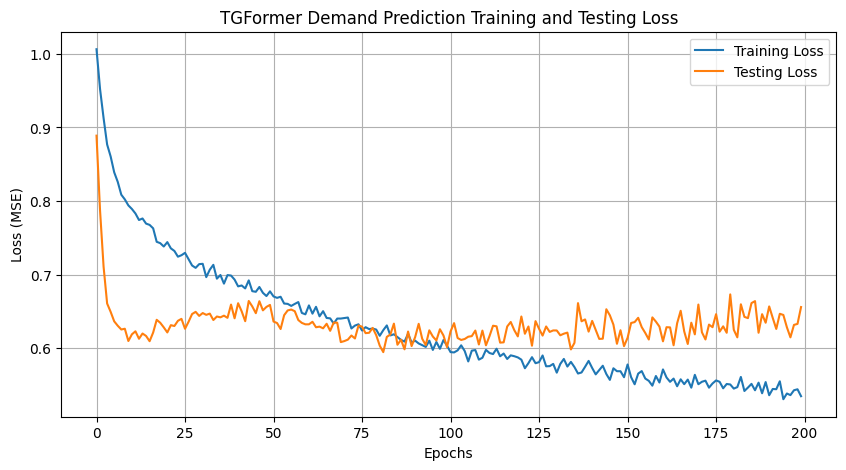

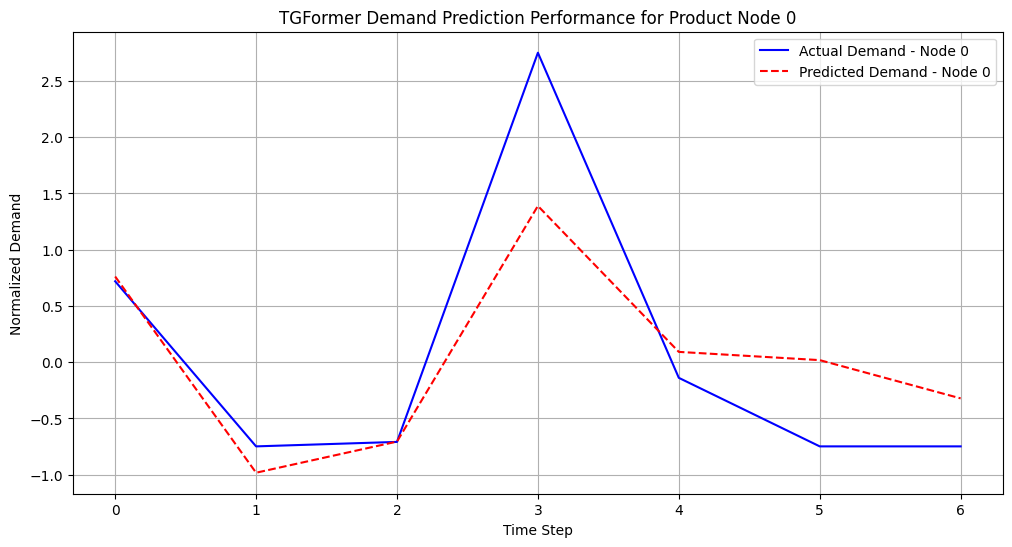

In [ ]:


# Define the TGFormer model
class TGFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout_rate=0.5):
        super(TGFormer, self).__init__()
        # First linear layer to process features
        self.linear1 = nn.Linear(input_dim, hidden_dim)

        # Transformer-based Graph Convolution
        self.transformer_conv1 = TransformerConv(hidden_dim, hidden_dim, heads=heads, dropout=dropout_rate)
        self.transformer_conv2 = TransformerConv(hidden_dim*heads, output_dim, heads=1, dropout=dropout_rate, concat=False)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        # Process input features first through linear layer
        x = self.linear1(x)
        x = self.relu(x)

        # First Transformer Conv layer
        x = self.transformer_conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Output Transformer Conv layer
        x = self.transformer_conv2(x, edge_index)
        return x

# Prepare data for the TransformerConv model
def prepare_data_for_transformer(sequences, labels, edge_index):
    data_list = []

    for i in range(len(sequences)):
        # Input sequence shape: (seq_length, num_nodes)
        seq = sequences[i]
        label = labels[i]

        # Create features for each node - transpose to shape [num_nodes, seq_length]
        x = torch.FloatTensor(seq.transpose(1, 0)).to(device)
        y = torch.FloatTensor(label).to(device)

        # Create PyG data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list

# Model parameters
hidden_dim = 16
heads = 4
seq_length = 5
learning_rate = 0.0005
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5

# Prepare data specifically for this model
train_data_list = prepare_data_for_transformer(sales_order_train_seqs, sales_order_train_labels, edge_index)
test_data_list = prepare_data_for_transformer(sales_order_test_seqs, sales_order_test_labels, edge_index)

# Initialize model
tgformer_model = TGFormer(
    input_dim=seq_length,
    hidden_dim=hidden_dim,
    output_dim=1,
    heads=heads,
    dropout_rate=dropout_rate
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tgformer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    # Training
    tgformer_model.train()
    epoch_loss = 0

    for data in train_data_list:
        optimizer.zero_grad()

        # Forward pass
        output = tgformer_model(data.x, data.edge_index).squeeze()
        loss = criterion(output, data.y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_data_list)
    train_losses.append(avg_train_loss)

    # Evaluation
    tgformer_model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in test_data_list:
            pred = tgformer_model(data.x, data.edge_index).squeeze()
            test_loss += criterion(pred, data.y).item()

    avg_test_loss = test_loss / len(test_data_list)
    test_losses.append(avg_test_loss)

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = tgformer_model.state_dict().copy()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Load best model for final evaluation
if best_model_state:
    tgformer_model.load_state_dict(best_model_state)

# Evaluate the model
tgformer_model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for data in train_data_list:
        pred = tgformer_model(data.x, data.edge_index).squeeze()
        train_preds.append(pred.cpu().numpy())

    for data in test_data_list:
        pred = tgformer_model(data.x, data.edge_index).squeeze()
        test_preds.append(pred.cpu().numpy())

# Convert predictions and ground truth to numpy arrays
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)
train_true = np.array([data.y.cpu().numpy() for data in train_data_list])
test_true = np.array([data.y.cpu().numpy() for data in test_data_list])

# Calculate error metrics
train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
train_mae = mean_absolute_error(train_true, train_preds)
test_mae = mean_absolute_error(test_true, test_preds)

print(f'TGFormer Demand Prediction Metrics:')
print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('TGFormer Demand Prediction Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions vs actual for a single product node
plt.figure(figsize=(12, 6))
node_idx = 0  # First product node
plt.plot([y[node_idx] for y in test_true], 'b-', label=f'Actual Demand - Node {node_idx}')
plt.plot([y[node_idx] for y in test_preds], 'r--', label=f'Predicted Demand - Node {node_idx}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Demand')
plt.title(f'TGFormer Demand Prediction Performance for Product Node {node_idx}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


# Function to move a model to CPU
def move_model_to_cpu(model):
    model.cpu()
    return model

# Function to move PyG data to CPU
def move_data_to_cpu(data_list):
    cpu_data_list = []
    for data in data_list:
        # Create a new data object with CPU tensors
        cpu_data = data.clone()
        cpu_data.x = data.x.cpu()
        cpu_data.y = data.y.cpu()
        cpu_data.edge_index = data.edge_index.cpu()
        cpu_data_list.append(cpu_data)
    return cpu_data_list

# Move all models to CPU
print("Moving models to CPU...")
demand_model = move_model_to_cpu(demand_model)
gcn_model = move_model_to_cpu(gcn_model)
gat_model = move_model_to_cpu(gat_model)
tgat_model = move_model_to_cpu(tgat_model)
tgformer_model = move_model_to_cpu(tgformer_model)

# Move data to CPU
print("Moving data to CPU...")
# For MLP
X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

# For graph-based models
train_data_list = move_data_to_cpu(train_data_list)
test_data_list = move_data_to_cpu(test_data_list)

# Move edge_index to CPU
edge_index = edge_index.cpu()

print("All models and data moved to CPU successfully!")

Moving models to CPU...
Moving data to CPU...
All models and data moved to CPU successfully!


Random seed set to 42
Saved MLP to saved_models/MLP.pt
Saved GCN to saved_models/GCN.pt
Saved GAT to saved_models/GAT.pt
Saved TGAT to saved_models/TGAT.pt
Saved TGFormer to saved_models/TGFormer.pt
Loaded MLP from saved_models/MLP.pt
Loaded GCN from saved_models/GCN.pt
Loaded GAT from saved_models/GAT.pt
Loaded TGAT from saved_models/TGAT.pt
Loaded TGFormer from saved_models/TGFormer.pt
Selected nodes for evaluation: [20, 3, 0, 23, 8]
Getting predictions for MLP...
Successfully generated predictions for MLP
Getting predictions for GCN...
Successfully generated predictions for GCN
Getting predictions for GAT...
Successfully generated predictions for GAT
Getting predictions for TGAT...
Successfully generated predictions for TGAT
Getting predictions for TGFormer...
Successfully generated predictions for TGFormer
Ground truth shape: (7, 27)

Prediction shapes:
MLP: (7, 27)
GCN: (7, 27)
GAT: (7, 27)
TGAT: (7, 27)
TGFormer: (7, 27)

Generating visualizations...
Creating grid visualization..

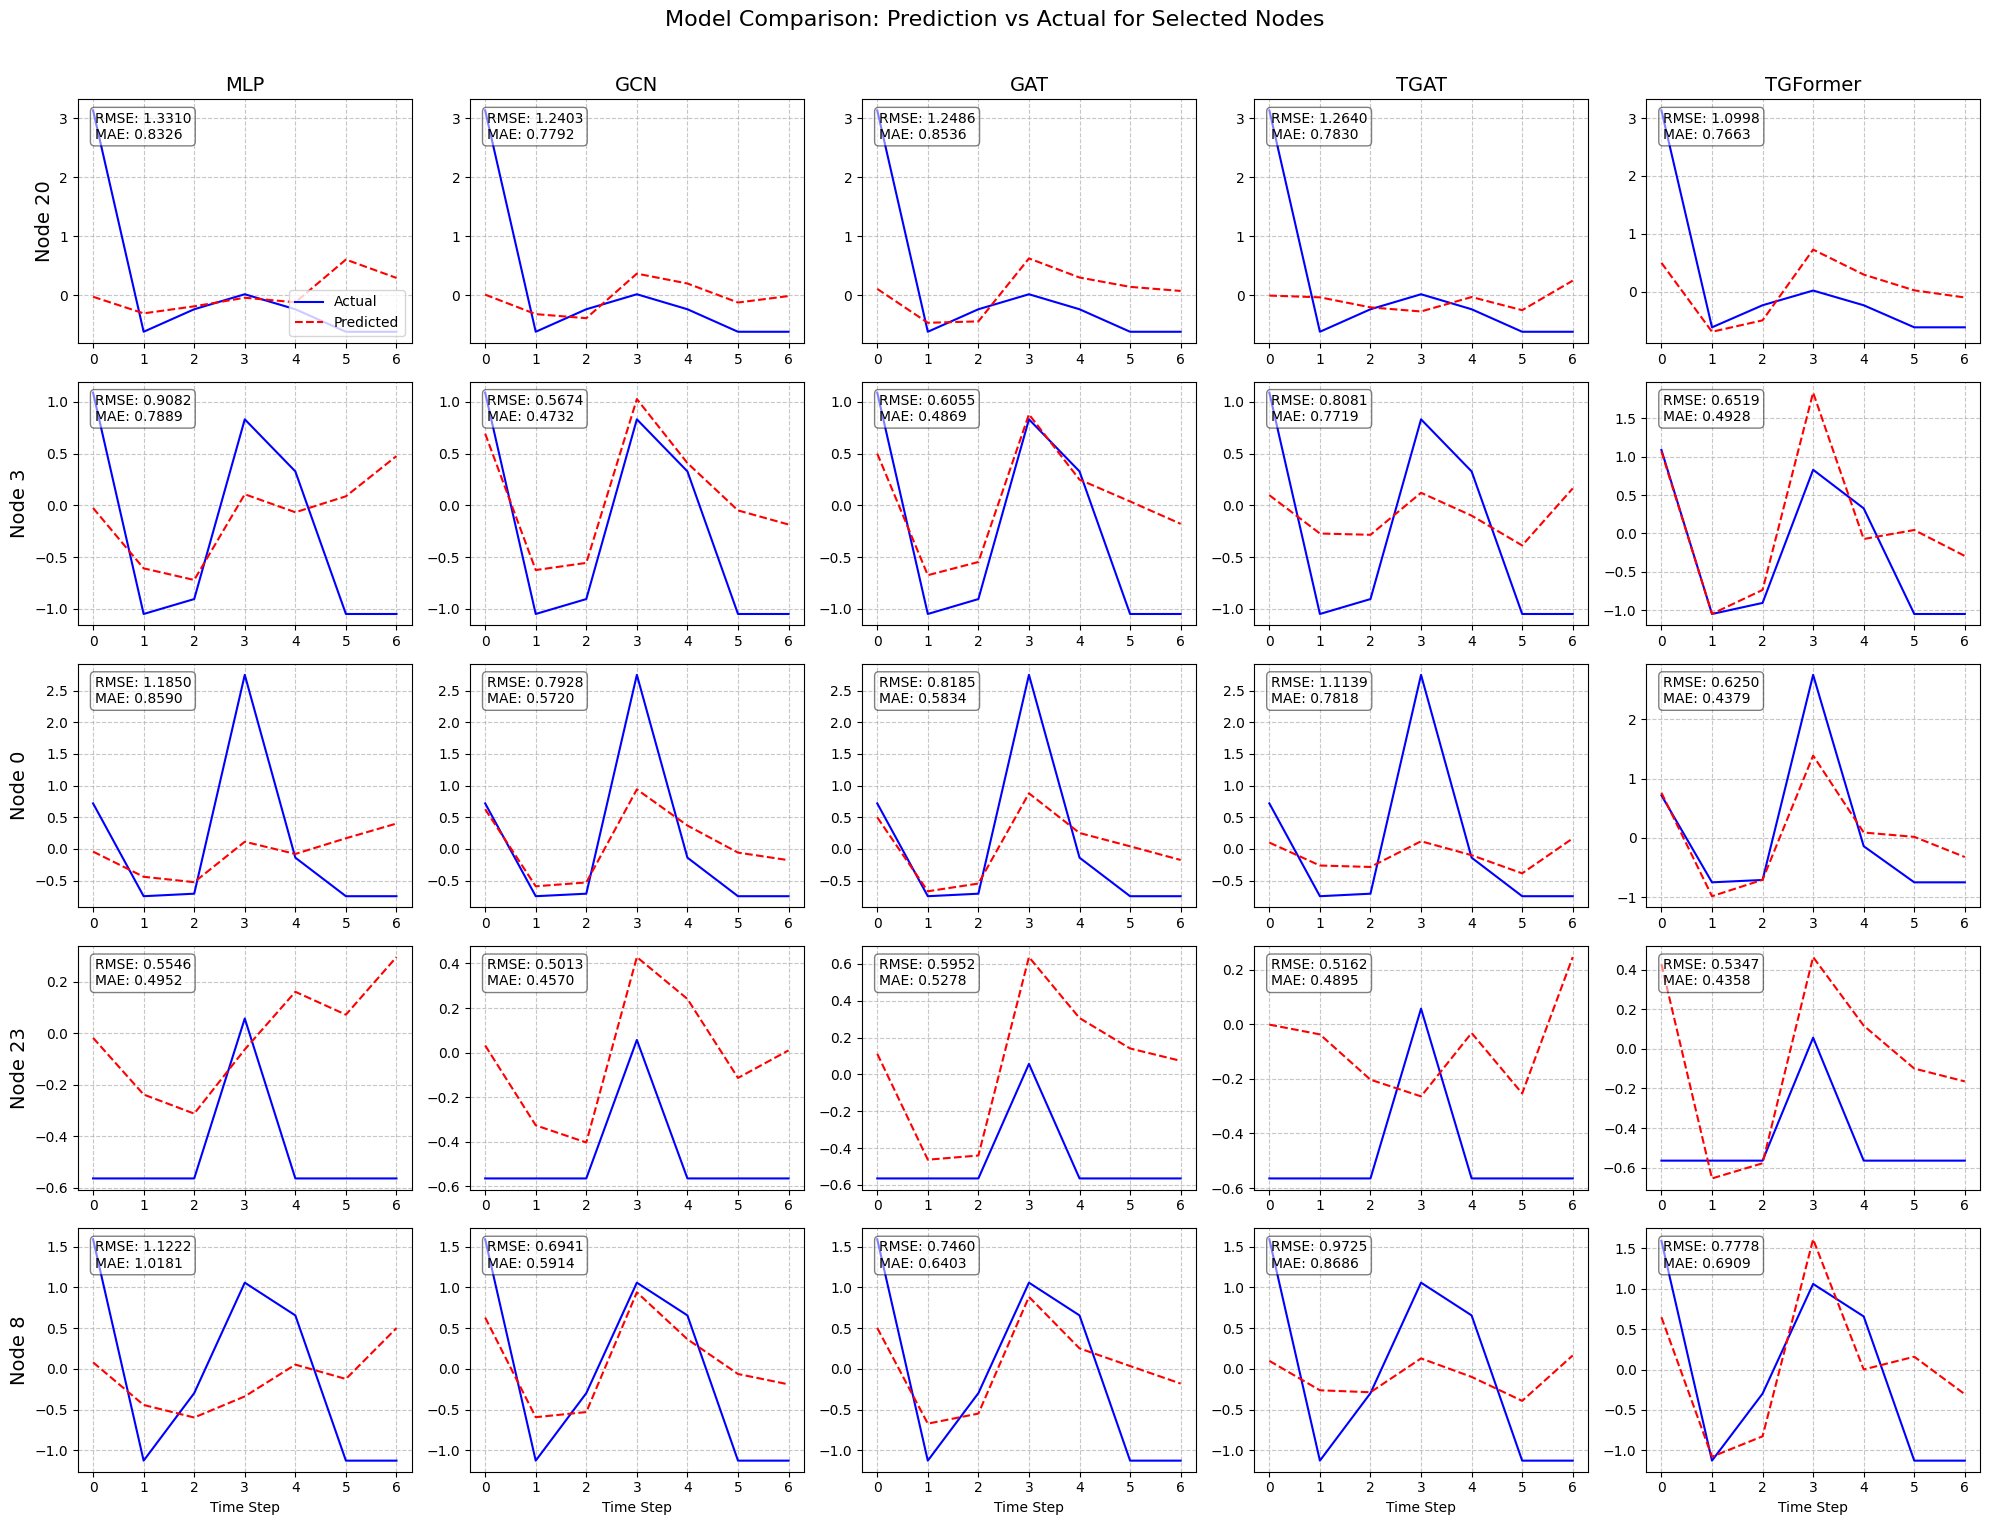

Grid visualization completed successfully
Creating comparison plot for node 20...


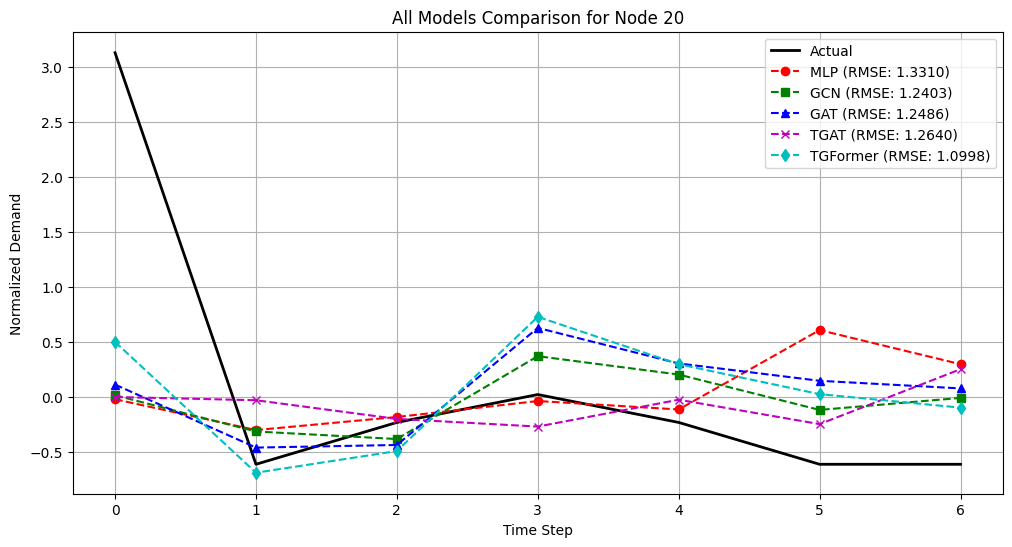

Plot for node 20 completed successfully
Creating comparison plot for node 3...


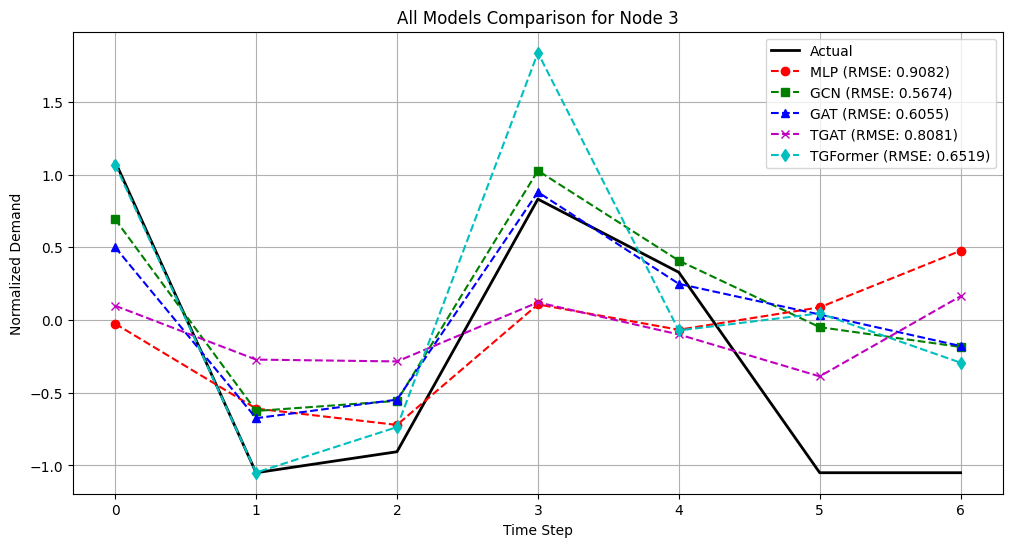

Plot for node 3 completed successfully
Creating comparison plot for node 0...


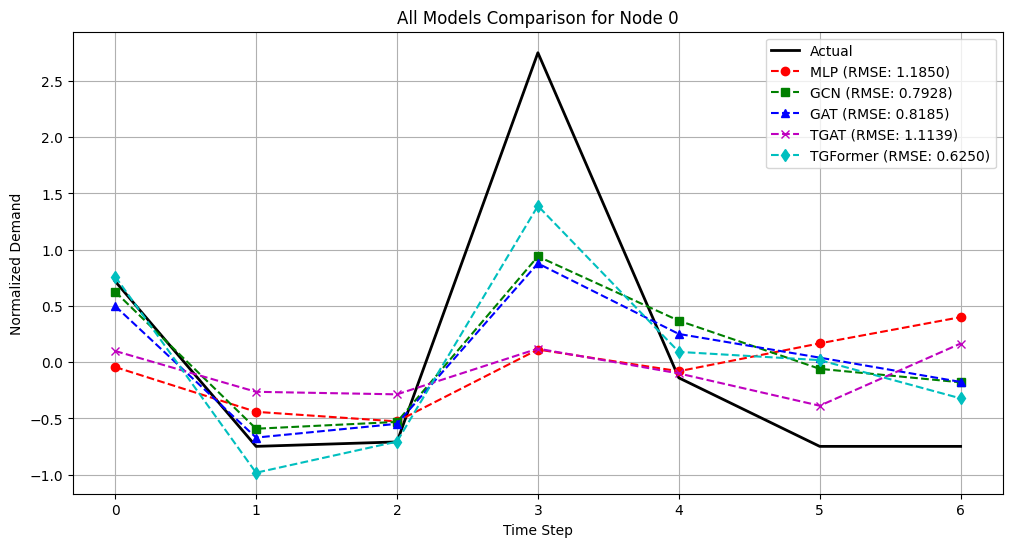

Plot for node 0 completed successfully
Creating comparison plot for node 23...


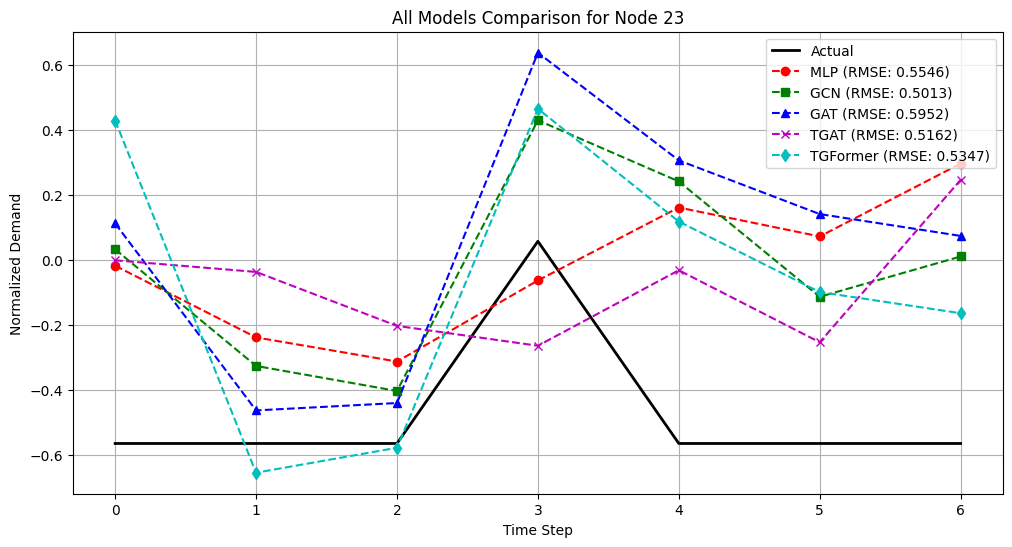

Plot for node 23 completed successfully
Creating comparison plot for node 8...


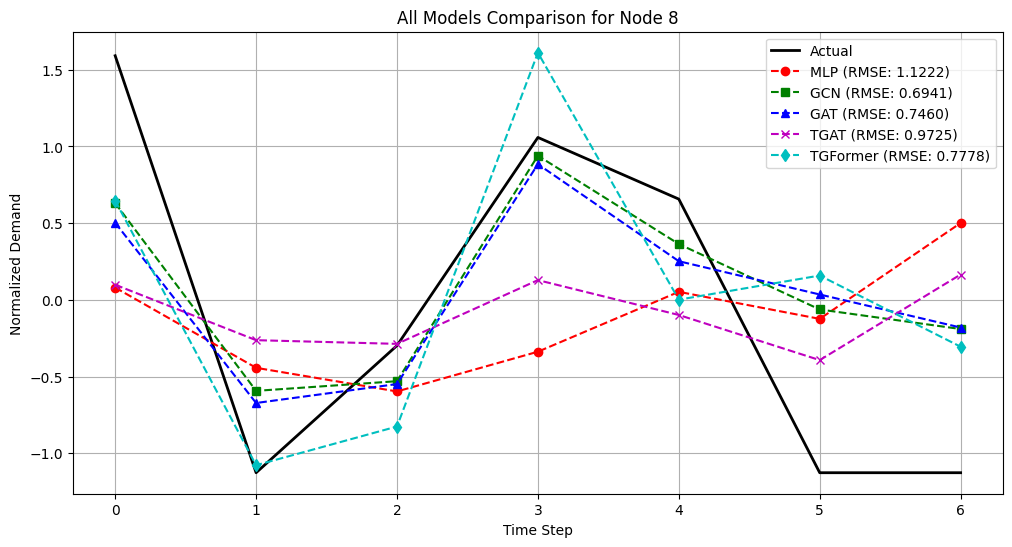

Plot for node 8 completed successfully

=== Model Performance Summary ===
Model      Avg RMSE     Avg MAE     
MLP        1.0202       0.7988      
GCN        0.7592       0.5746      
GAT        0.8028       0.6184      
TGAT       0.9349       0.7390      
TGFormer   0.7378       0.5647      

=== Detailed Node Metrics ===

Node 20:
Model      RMSE         MAE         
-----------------------------------
MLP        1.3310       0.8326      
GCN        1.2403       0.7792      
GAT        1.2486       0.8536      
TGAT       1.2640       0.7830      
TGFormer   1.0998       0.7663      

Node 3:
Model      RMSE         MAE         
-----------------------------------
MLP        0.9082       0.7889      
GCN        0.5674       0.4732      
GAT        0.6055       0.4869      
TGAT       0.8081       0.7719      
TGFormer   0.6519       0.4928      

Node 0:
Model      RMSE         MAE         
-----------------------------------
MLP        1.1850       0.8590      
GCN        0.7928  

In [ ]:


# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# Set the random seed
set_seed(42)

# Create directory to save models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save the best models
def save_models(models_dict):
    for model_name, model in models_dict.items():
        # Move model to CPU before saving to avoid GPU/CPU device mismatches
        model.cpu()
        save_path = f"saved_models/{model_name}.pt"
        torch.save(model.state_dict(), save_path)
        print(f"Saved {model_name} to {save_path}")

# Load the best models
def load_models(models_dict):
    # Always load to CPU to avoid device mismatches
    loaded_models = {}

    for model_name, model in models_dict.items():
        load_path = f"saved_models/{model_name}.pt"
        if os.path.exists(load_path):
            # Explicitly load to CPU
            model.load_state_dict(torch.load(load_path, map_location='cpu'))
            model.cpu()
            model.eval()
            loaded_models[model_name] = model
            print(f"Loaded {model_name} from {load_path}")
        else:
            # If file doesn't exist, still use the model but ensure it's on CPU
            model.cpu()
            model.eval()
            loaded_models[model_name] = model
            print(f"Warning: Model file for {model_name} not found at {load_path}. Using current model state.")

    return loaded_models

# 1. Define model dictionaries with their best states
# Modify these with your actual models and their best states
models_dict = {
    'MLP': demand_model,
    'GCN': gcn_model,
    'GAT': gat_model,
    'TGAT': tgat_model,
    'TGFormer': tgformer_model
}

# 2. Save all models
save_models(models_dict)

# 3. Load all models
loaded_models = load_models(models_dict)

# 4. Select 5 random nodes for evaluation
num_nodes = 27  # Based on your code
num_nodes_to_test = 5

# Set random seed again to ensure node selection is reproducible
random.seed(42)
random_nodes = random.sample(range(num_nodes), num_nodes_to_test)
print(f"Selected nodes for evaluation: {random_nodes}")

# 5. Make predictions for all models on the validation/test set for these nodes
def get_model_predictions(model_name, model, data_list):
    # Ensure model is on CPU and in eval mode
    model.cpu()
    model.eval()
    predictions = []

    with torch.no_grad():
        for data in data_list:
            # Handle different model architectures based on their type
            if model_name == 'MLP':
                # Reshape input for MLP (flattened sequence)
                x = data.x.view(1, -1).cpu()  # Flatten to match MLP input shape
                pred = model(x).squeeze().cpu().numpy()
            elif model_name == 'TGAT':
                # TGAT expects 3D tensors: [batch_size, num_nodes, seq_len]
                x = data.x.cpu()
                edge_index = data.edge_index.cpu()
                # Reshape to match TGAT's expected input format
                x = x.unsqueeze(0)  # Add batch dimension [1, num_nodes, seq_len]
                pred = model(x, edge_index).squeeze().cpu().numpy()
            else:
                # For other graph-based models (GCN, GAT, TGFormer)
                x = data.x.cpu()
                edge_index = data.edge_index.cpu()
                pred = model(x, edge_index).squeeze().cpu().numpy()

            predictions.append(pred)

    return np.array(predictions)

# Create custom prediction functions for each model
def predict_mlp(model, data):
    # For MLP, we use X_test_tensor directly
    model.cpu()
    model.eval()
    with torch.no_grad():
        X_test_cpu = X_test_tensor.cpu()
        pred = model(X_test_cpu).detach().cpu().numpy()
    return pred

def predict_gcn(model, data_list):
    model.cpu()
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_list:
            x = data.x.cpu()
            edge_index = data.edge_index.cpu()
            pred = model(x, edge_index).squeeze().cpu().numpy()
            predictions.append(pred)
    return np.array(predictions)

def predict_gat(model, data_list):
    model.cpu()
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_list:
            x = data.x.cpu()
            edge_index = data.edge_index.cpu()
            pred = model(x, edge_index).squeeze().cpu().numpy()
            predictions.append(pred)
    return np.array(predictions)

def predict_tgat(model, data_list):
    model.cpu()
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_list:
            x = data.x.cpu()
            edge_index = data.edge_index.cpu()
            # TGAT expects [batch_size, num_nodes, seq_len]
            x = x.unsqueeze(0)  # Add batch dimension
            try:
                pred = model(x, edge_index).squeeze().cpu().numpy()
            except ValueError:
                # If that doesn't work, try calling with an explicit time_idx=None
                pred = model(x, edge_index, time_idx=None).squeeze().cpu().numpy()
            predictions.append(pred)
    return np.array(predictions)

def predict_tgformer(model, data_list):
    model.cpu()
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_list:
            x = data.x.cpu()
            edge_index = data.edge_index.cpu()
            pred = model(x, edge_index).squeeze().cpu().numpy()
            predictions.append(pred)
    return np.array(predictions)

# Dictionary mapping model names to prediction functions
prediction_functions = {
    'MLP': predict_mlp,
    'GCN': predict_gcn,
    'GAT': predict_gat,
    'TGAT': predict_tgat,
    'TGFormer': predict_tgformer
}

# Get predictions for all models
all_predictions = {}
for model_name, model in loaded_models.items():
    print(f"Getting predictions for {model_name}...")
    try:
        # Use the appropriate prediction function for each model
        if model_name == 'MLP':
            preds = prediction_functions[model_name](model, None)
        else:
            preds = prediction_functions[model_name](model, test_data_list)
        all_predictions[model_name] = preds
        print(f"Successfully generated predictions for {model_name}")
    except Exception as e:
        print(f"Error generating predictions for {model_name}: {str(e)}")
        # If prediction fails, create a dummy prediction with zeros to avoid breaking the code
        dummy_shape = (len(test_data_list), num_nodes)
        all_predictions[model_name] = np.zeros(dummy_shape)
        print(f"Using zeros as placeholder predictions for {model_name}")

# Get ground truth values
try:
    true_values = np.array([data.y.cpu().numpy() for data in test_data_list])
    print(f"Ground truth shape: {true_values.shape}")
except Exception as e:
    print(f"Error converting ground truth values: {str(e)}")
    # Create dummy ground truth values if needed
    dummy_shape = (len(test_data_list), num_nodes)
    true_values = np.zeros(dummy_shape)
    print(f"Using zeros as placeholder for ground truth")

# Print shape information to help debugging
print("\nPrediction shapes:")
for model_name, preds in all_predictions.items():
    print(f"{model_name}: {preds.shape}")

# Check for any shape mismatches
shape_mismatch = False
expected_shape = None
for model_name, preds in all_predictions.items():
    if expected_shape is None:
        expected_shape = preds.shape
    elif preds.shape != expected_shape:
        print(f"WARNING: Shape mismatch for {model_name}. Expected {expected_shape}, got {preds.shape}")
        shape_mismatch = True

if shape_mismatch:
    print("Attempting to fix shape mismatches...")
    # Resize predictions to match the first model's shape
    for model_name, preds in all_predictions.items():
        if preds.shape != expected_shape:
            print(f"Resizing {model_name} predictions from {preds.shape} to {expected_shape}")
            # Simple approach: pad or truncate to match expected shape
            resized_preds = np.zeros(expected_shape)
            min_rows = min(preds.shape[0], expected_shape[0])
            min_cols = min(preds.shape[1], expected_shape[1])
            resized_preds[:min_rows, :min_cols] = preds[:min_rows, :min_cols]
            all_predictions[model_name] = resized_preds

# 6. Create a 5x5 grid of plots (5 models x 5 nodes)
def plot_predictions_grid(all_predictions, true_values, random_nodes):
    models = list(all_predictions.keys())

    fig, axes = plt.subplots(len(random_nodes), len(models), figsize=(20, 16))
    fig.suptitle('Model Comparison: Prediction vs Actual for Selected Nodes', fontsize=16)

    # Add column headers (model names)
    for i, model_name in enumerate(models):
        axes[0, i].set_title(model_name, fontsize=14)

    # Add row headers (node indices)
    for i, node_idx in enumerate(random_nodes):
        axes[i, 0].set_ylabel(f'Node {node_idx}', fontsize=14)

    # Plot for each node and model
    for i, node_idx in enumerate(random_nodes):
        for j, model_name in enumerate(models):
            ax = axes[i, j]

            # Extract predictions and true values for this node
            preds = all_predictions[model_name][:, node_idx]
            actuals = [y[node_idx] for y in true_values]

            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(actuals, preds))
            mae = mean_absolute_error(actuals, preds)

            # Plot
            time_steps = range(len(preds))
            ax.plot(time_steps, actuals, 'b-', label='Actual')
            ax.plot(time_steps, preds, 'r--', label='Predicted')

            # Add metrics as text
            ax.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}',
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

            if i == len(random_nodes) - 1:  # Only add x-label for bottom row
                ax.set_xlabel('Time Step')

            if i == 0 and j == 0:  # Only add legend for top-left plot
                ax.legend(loc='lower right')

            # Add grid
            ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust for the title
    plt.savefig('model_comparison_grid.png', dpi=300, bbox_inches='tight')
    plt.show()

# 7. Create a subplot showing all models' predictions for a single node
def plot_all_models_single_node(all_predictions, true_values, node_idx):
    models = list(all_predictions.keys())

    plt.figure(figsize=(12, 6))

    # Plot actual values
    time_steps = range(len(true_values))
    actuals = [y[node_idx] for y in true_values]
    plt.plot(time_steps, actuals, 'k-', linewidth=2, label='Actual')

    # Plot predictions for each model
    colors = ['r', 'g', 'b', 'm', 'c']
    markers = ['o', 's', '^', 'x', 'd']

    for i, model_name in enumerate(models):
        preds = all_predictions[model_name][:, node_idx]
        plt.plot(time_steps, preds, colors[i], linestyle='--', marker=markers[i],
                 label=f'{model_name} (RMSE: {np.sqrt(mean_squared_error(actuals, preds)):.4f})')

    plt.title(f'All Models Comparison for Node {node_idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Demand')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(f'all_models_node_{node_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. Run the visualizations with error handling
print("\nGenerating visualizations...")

try:
    # 5x5 grid for all models and selected nodes
    print("Creating grid visualization...")
    plot_predictions_grid(all_predictions, true_values, random_nodes)
    print("Grid visualization completed successfully")
except Exception as e:
    print(f"Error creating grid visualization: {str(e)}")

# For each selected node, plot all models' predictions
for node_idx in random_nodes:
    try:
        print(f"Creating comparison plot for node {node_idx}...")
        plot_all_models_single_node(all_predictions, true_values, node_idx)
        print(f"Plot for node {node_idx} completed successfully")
    except Exception as e:
        print(f"Error creating plot for node {node_idx}: {str(e)}")

# 9. Create a summary table of metrics for all models across all nodes
def create_metrics_summary(all_predictions, true_values, random_nodes):
    models = list(all_predictions.keys())
    metrics = {}

    for model_name in models:
        node_metrics = {}
        for node_idx in random_nodes:
            preds = all_predictions[model_name][:, node_idx]
            actuals = [y[node_idx] for y in true_values]

            rmse = np.sqrt(mean_squared_error(actuals, preds))
            mae = mean_absolute_error(actuals, preds)

            node_metrics[node_idx] = {'RMSE': rmse, 'MAE': mae}

        # Calculate average metrics across all selected nodes
        avg_rmse = np.mean([node_metrics[node]['RMSE'] for node in node_metrics])
        avg_mae = np.mean([node_metrics[node]['MAE'] for node in node_metrics])

        metrics[model_name] = {
            'node_metrics': node_metrics,
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae
        }

    # Print summary table
    print("\n=== Model Performance Summary ===")
    print(f"{'Model':<10} {'Avg RMSE':<12} {'Avg MAE':<12}")
    print("="*35)

    for model_name, model_metrics in metrics.items():
        print(f"{model_name:<10} {model_metrics['avg_rmse']:<12.4f} {model_metrics['avg_mae']:<12.4f}")

    print("\n=== Detailed Node Metrics ===")
    for node_idx in random_nodes:
        print(f"\nNode {node_idx}:")
        print(f"{'Model':<10} {'RMSE':<12} {'MAE':<12}")
        print("-"*35)

        for model_name in models:
            node_metric = metrics[model_name]['node_metrics'][node_idx]
            print(f"{model_name:<10} {node_metric['RMSE']:<12.4f} {node_metric['MAE']:<12.4f}")

    return metrics

# Generate and print metrics summary
metrics_summary = create_metrics_summary(all_predictions, true_values, random_nodes)

# Saving All Information Relevant to Azure Deployment

In [ ]:


# Create directory for saving data
os.makedirs('deployment_assets', exist_ok=True)

print("Saving validation data...")

# Save the validation/test data for later use
validation_data = {
    # Save test data for MLP
    'X_test_tensor': X_test_tensor.cpu(),
    'y_test_tensor': y_test_tensor.cpu(),

    # Save graph structure
    'edge_index': edge_index.cpu(),

    # Save test data for graph models
    'test_data_list': test_data_list,

    # Save node mapping (important for interpretability)
    'node_mapping': node_mapping,

    # Save random nodes used for visualization
    'random_nodes': random_nodes
}

# Save the data using pickle
with open('deployment_assets/validation_data.pkl', 'wb') as f:
    pickle.dump(validation_data, f)

# Also save in torch format for easier loading in production
torch.save(validation_data, 'deployment_assets/validation_data.pt')

print("Validation data saved to 'deployment_assets/validation_data.pkl' and 'deployment_assets/validation_data.pt'")

# Additionally, save a small sample for quick testing
sample_data = {
    'edge_index': edge_index.cpu(),
    'sample_node_features': test_data_list[0].x.cpu(),
    'sample_node_mapping': node_mapping
}

torch.save(sample_data, 'deployment_assets/sample_data.pt')
print("Sample data saved to 'deployment_assets/sample_data.pt'")

Saving validation data...
Validation data saved to 'deployment_assets/validation_data.pkl' and 'deployment_assets/validation_data.pt'
Sample data saved to 'deployment_assets/sample_data.pt'


In [ ]:


# Create directory for environment info
os.makedirs('deployment_assets', exist_ok=True)

print("Exporting environment information...")

# Get Python version
python_version = sys.version
print(f"Python version: {python_version}")

# Get PyTorch version and CUDA availability
torch_version = torch.__version__
cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "Not available"
print(f"PyTorch version: {torch_version}")
print(f"CUDA available: {cuda_available}")
print(f"CUDA version: {cuda_version}")

# Get platform information
platform_info = {
    "system": platform.system(),
    "release": platform.release(),
    "version": platform.version(),
    "machine": platform.machine(),
    "processor": platform.processor()
}

# Get installed packages with versions
installed_packages = sorted([f"{pkg.key}=={pkg.version}" for pkg in pkg_resources.working_set])

# Try to generate requirements.txt
try:
    # pip freeze approach
    result = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
                           capture_output=True, text=True, check=True)
    requirements = result.stdout

    with open('deployment_assets/requirements.txt', 'w') as f:
        f.write(requirements)
    print("Generated requirements.txt successfully")
except Exception as e:
    print(f"Error generating requirements.txt: {str(e)}")
    # Fallback method
    with open('deployment_assets/requirements.txt', 'w') as f:
        f.write('\n'.join(installed_packages))
    print("Generated requirements.txt using fallback method")

# Create a comprehensive environment report
environment_info = {
    "python_version": python_version,
    "pytorch_version": torch_version,
    "cuda_available": cuda_available,
    "cuda_version": cuda_version,
    "platform": platform_info,
    "packages": installed_packages
}

# Save environment report as JSON
with open('deployment_assets/environment_info.json', 'w') as f:
    json.dump(environment_info, f, indent=2)
print("Environment information saved to 'deployment_assets/environment_info.json'")

# Create a Docker starter file
dockerfile_content = """
FROM python:3.11-slim

WORKDIR /app

# Copy requirements
COPY deployment_assets/requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy model files and code
COPY saved_models/ /app/saved_models/
COPY deployment_assets/ /app/deployment_assets/
COPY inference.py .

# Run the inference API
CMD ["python", "inference.py"]
"""

with open('deployment_assets/Dockerfile', 'w') as f:
    f.write(dockerfile_content)
print("Dockerfile template saved to 'deployment_assets/Dockerfile'")

Exporting environment information...
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Generated requirements.txt successfully
Environment information saved to 'deployment_assets/environment_info.json'
Dockerfile template saved to 'deployment_assets/Dockerfile'
